<a href="https://colab.research.google.com/github/m-wessler/nbm-verification/blob/main/NBM_Threshold_Probs_vs_Obs_LSR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**NBM Probabilistic Plotter**

This notebook combines two preview notebooks to plot probailistic NBM temperature and precipitation data along with limited qualitative "verification" data (obs/LSRs). This notebook is meant to be used in the google colab environment and built with NWS SOOs in mind; so it may need adjustments if used elsewhere by others. Uses some code borrowed from [Brian Blaylock](https://github.com/blaylockbk) to more efficiently access the [NBM grib archive on AWS](https://noaa-nbm-grib2-pds.s3.amazonaws.com/index.html) for data, matplotlib, cartopy, and contextily to plot, [synoptic data preciptation api](https://developers.synopticdata.com/mesonet/v2/stations/precipitation/) for precipitation obs / [synoptic data](https://synopticdata.com/mesonet-api) statistics api for Min/Max T obs *(only tested with NOAA/NWS accounts)*, and [Iowa State LSR api](https://mesonet.agron.iastate.edu/request/gis/lsrs.phtml) for LSRs. Feel free to improve, steal, or use as a springboard for your own endeavours! <br/>
<br/>
Caleb Steele - https://github.com/csteele2/Wx4Colab
<br/>

> 21-Dec-2023: Just a few tweaks to keep it working with past events, and to also remove stamen maps.

> 10-Oct-2023: Since cfgrib kinda stopped working with the existing implementation of condacolab, and since condacolab isn't necessary anymore now that google colab is on py 3.10+, removed the install of conda colab (which removed a step and error message! yay!)

> 12-Sept-2023: Just a few tweaks and bug fixes. Changed the projection of CONUS from mercator so it isn't so distorted anymore (especially at higher latitudes). Added a workaround for the lowest (0.10") threshold of psnow so it should also work again.

> 12-Apr-2023: Added prob daily max wind plots. Since the precomputed threholds are more valid for old school marine forecasting, decided to add a function to interpolate to any desired threshold from the percentiles. Also applied this to PQPF, since I was lazy and didn't want to look up what thresholds are valid for 24, 48, and 72-hr PQPF (they are different). Unfortunately, since I switched to xarray/cfgrib, this needs a loop to decode the 99 percentiles individually, so it does add about 30 seconds to run time.

> 17-Jan-2023: Some tweaks (like the CO domain) and updates to account for NBM v4.1 implementation. In NBM 4.1, PWPF (pSnow, pIce) are tied to PQPF, thus are not run every hour. However, they are not inserted into the QMD files, rather included in the next available core file, which is the QMD cycle + 7 hours (i.e. the 12Z QMD run PWPF is available in the 19Z core files, but PQPF, which it is tied to, retains the QMD cycling scheme. Which means the PQPF and PWPF from the same cycle will have different forecast hours). I account for this in the code, but its clear as mud, right?

> 28-Dec-2022: A few bug fixes, especially related to PMxMnT option regarding legend, title, and filename

> 22-Dec-2022: Initial release of combined notebook that uses xarray vice pygrib to read grib files

## **1 - Install and Import**

This will install and import everything we need. You need only run this once per session, then you can make all the changes to the form and make as many plots as you wish without having to rerun this cell (unless your session expires and spins down).

In [ ]:
!pip install ecmwflibs
!pip install eccodes
!pip install cfgrib
!pip install cartopy contextily pyproj pyepsg netCDF4 xarray

import numpy as np # to deal with arrays and math
import xarray as xr # for reading gribs
from urllib.request import urlretrieve # to get files
import requests # to read a remote file
import os, re, traceback # to do sorcery with subsetting nbm gribs

import matplotlib # for plotting
import matplotlib.patches as mpatches # helps us make a custom legend
import matplotlib.pyplot as plt # to make actual plots
import matplotlib.axes as maxes
import matplotlib.patheffects as PathEffects # to add outline to text, etc.
from matplotlib.path import Path
from matplotlib.textpath import TextToPath
from matplotlib.font_manager import FontProperties # we use this to use a custom font as markers
matplotlib.rcParams['font.sans-serif'] = 'Liberation Sans'
matplotlib.rcParams['font.family'] = "sans-serif"

import pandas as pd # convenient to organize LSRs and obs
import json # for parsing the syntopic api return
from pyproj.crs import CRS # to warp maptiles

from datetime import datetime, timedelta # to deal with datetime objects

from cartopy import crs as ccrs, feature as cfeature # to make the plots maps
from cartopy.io.shapereader import Reader # to read shapefiles
from cartopy.feature import ShapelyFeature # also to read shapefiles
import contextily as cx # to get fancy maptiles

import warnings # to squash warnings that I have deemed insignificant
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 MB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for findlibs: filename=findlibs-0.0.5-py3-none-any.whl size=6941 sha256=3a6e71ded99453da2713fd2851a56afb74ca36fe70683e223f386f5bbc356b04
  Stored in directory: /root/.cache/pip/wheels/2e/67/14/22fa5b9fd9c41be520b37e908597d6a262803c0fcf2ba7c2c3
Successfully built findlibs
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eccodes: filename=eccodes-1.7.0-py3-none-any.whl size=41293 sha256=ae933ca68e34ee15fae91b985a3eedcbc1b5ad7d8510f4a3b2551297a4bb1198
  Stored in directory: /root/.cache/pip/wheels/44/16/96/7b9c3092abbd09c79444ba34e07106bc0992eb1c9e05fd58f3
Successfully built eccodes
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 776.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

## **2 - Edit Form Options & Go!**

The cell below has some config things to set. For the curious, you can unhide the code hiding underneath.

Figuring out what to do based on your inputs...
Getting and processing NBM...
  > Downloading a subset of NBM gribs
      ✅ Success! Searched for [:APCP:surface:0-3 day acc fcst:] and got [110] GRIB fields and saved as nbm/blend.t12z.qmd.2024032712f072.co.pqpf72_subset.grib2
  > Deriving probability of exceedance
   ✅ Got it! Max: 99
Making QPF probability plot
 > Initializing map
 > Adding fancy map tiles
    ❌ Aw shucks, no CWA boundaries for you. Sorry bout that.
 > Contouring NBM
 > Getting obs
   ✅ ...and plotted!
 > Finishing up map and adding legend
 > Saving plot as WR_probqpf72_1_2024032712T2024033012.png


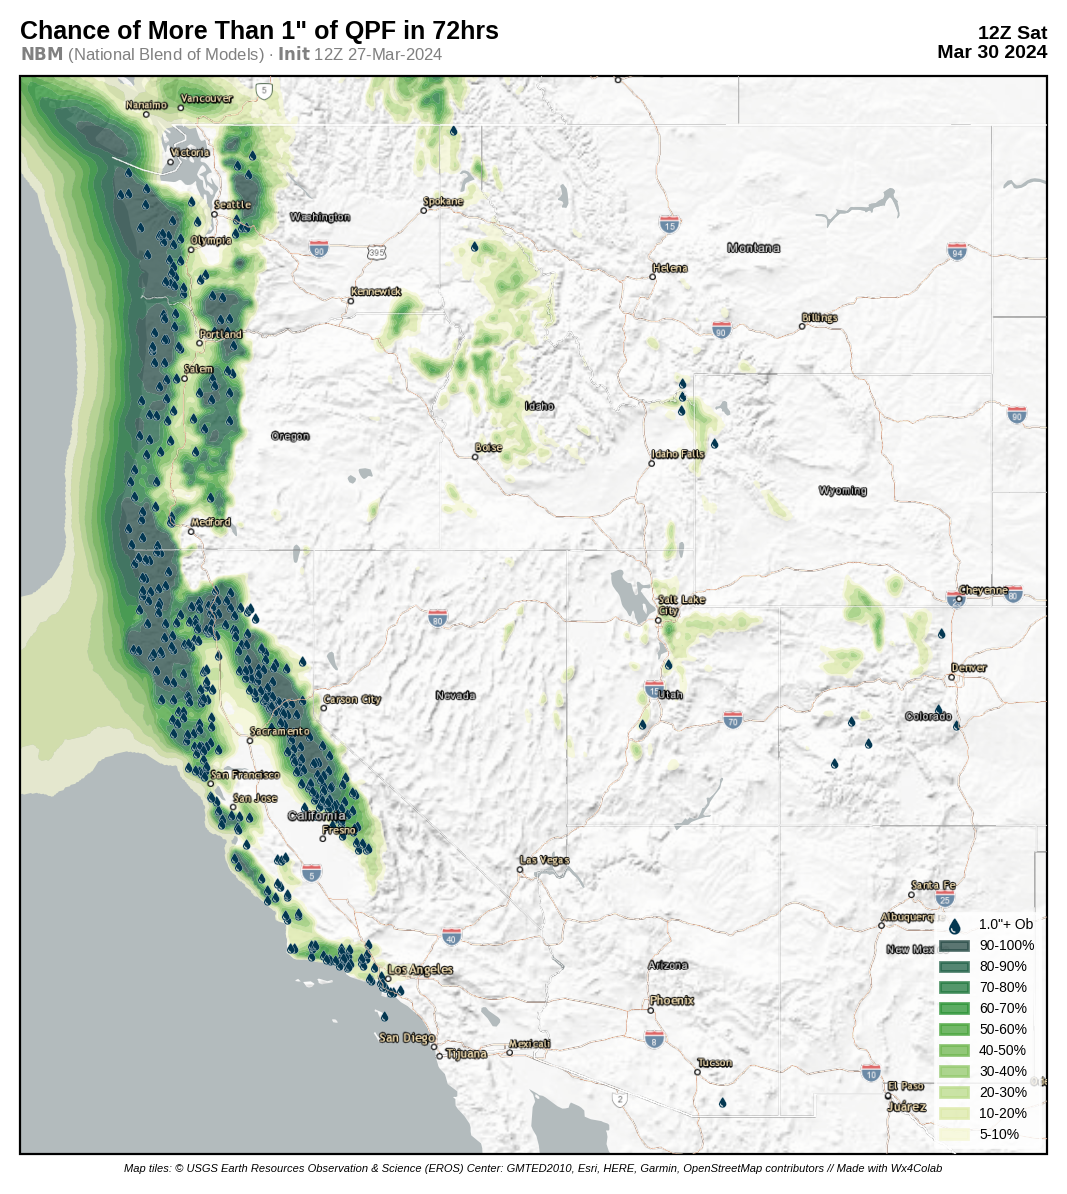

In [ ]:
from numpy.ma.core import flatten_mask
#@title Plot Config { vertical-output: true, display-mode: "form" }
# If this looks weird (like code instead of a form), try opening on Colab for the best experience!
#@markdown ##<b>--------------- NBM Selection --------------- </b><br/>
nbm_var = "PQPF" #@param ["PQPF", "PMxMnT", "PMxWind"]
#@markdown Choose Valid (ending) date & hour (UTC) (hour not needed for PMxMnT or PMxWind)
valid_date = "2024-03-30" #@param {type:"date"}
valid_hour = 12 #@param {type:"slider", min:0, max:18, step:6}
#@markdown Choose NBM QMD initialization date/hour (UTC) (PWPF is every hour, but PQPF is only 00/06/12/18Z).
init_date = "2024-03-27" #@param {type:"date"}
init_hour = 12 #@param {type:"slider", min:0, max:18, step:6}

#@markdown ### <b>--------------- PQPF Options ---------------</b> <br/>
#@markdown Choose the length of your forecast period (PQPF is only 24-hr pre-v4.1 upgrade (17-Jan-2023), otherwise 24, 48, or 72-hr available).
forecast_length = "72" #@param [24, 48, 72]
forecast_length = str(forecast_length)
#@markdown Which precipitation type? (Snow, Ice, or QPF)
ptype = "qpf" #@param ["snow", "ice", "qpf"]
#@markdown Do you want a probability of exceedance or a percentile?
pqpf_var = "prob" #@param ["prob", "percentile"]
#vt = "2022-02-04T12:00" #@param {type:"string"}
#init = "2022-01-31T13:00" #@param {type:"string"}
#@markdown Choose value or exceedance or percentile (you only need to change one / whichever variable you picked earlier)
#@markdown Note: not all thresholds are available for all forecast lengths!
threshold_qpf = 1 #@param type: number
#threshold_qpf = "{:.2f}".format(threshold_qpf)
#threshold_qpf = str(threshold_qpf)
PQPF_thresh_dict = {"24":["0.01", "0.10", "0.25", "0.50", "1.00", "2.00", "3.00", "4.00", "5.00", "6.00"],
                    "48":["0.10", "1.00", "2.00", "4.00", "6.00", "8.00", "12.00", "18.00", "24.00", "30.00"],
                    "72":["0.10", "1.00", "2.00", "4.00", "6.00", "8.00", "12.00", "18.00", "24.00", "30.00"]}
#@markdown Do you want a tabbed overview? Otherwise, a single plot will be returned. (In development - only for pqpf for now)
overview_opt = False#@param {type:"boolean"}

#@markdown Otherwise, select threshold below.
threshold_ice = "0.10" #@param ["0.01", "0.10", "0.25", "0.50", "1.00"]
threshold_snow = "1.00" #@param ["0.10", "1.00", "2.00", "4.00", "6.00", "8.00", "12.00", "18.00", "24.00", "30.00"]
pqpf_threshold_percentile = "90" #@param ["5", "10", "25", "50", "75", "90", "95"]
threshold_dict = {"0.01":"0.254","0.10":"2.54","0.25":"6.35","0.50":"12.7",
                  "1.00":"25.4","2.00":"50.8","3.00":"76.2","4.00":"101.6",
                  "5.00":"127","6.00":"152.4","8.00":"203.2","12.00":"304.8",
                  "18.00":"457.2","24.00":"609.6","30.00":"762"}
perc_suffix_dict = dict.fromkeys(["5","10","25","50","75","90","95", "99"],"th")
perc_suffix_dict.update(dict.fromkeys(['1'], "st"))
#if ptype == "qpf":
  #threshold_mm = threshold_dict[threshold_qpf]
if ptype == "snow":
  threshold_mm = threshold_dict[threshold_snow]
elif ptype == "ice":
  threshold_mm = threshold_dict[threshold_ice]
#threshold = "025" #@param {type:"string"}
#@markdown <br />

#@markdown ### <b>--------------- PMxMnT Options --------------- </b><br/>
#@markdown Which temperature type? (MaxT or MinT)
temp = "MinT" #@param ["MinT", "MaxT"]
#@markdown Choose non/exeedance threshold
#@markdown HotMaxT: 80, 90, 100, 110, 120 | ColdMaxT: 0, 28, 32 | ColdMinT: -40, -20,  0, 28, 32 | HotMinT: 80
threshold_temp = 0 #@param [-40, -20, 0, 28, 32, 80, 90, 100, 110, 120]{type:"raw"}

threshold_dict_FK = {-40:233,-20:244,0:255,28:270,
                  32:273,80:299, 90:305,100:310,110:316,120:322}
threshold_dict_prob = {"5":"05","10":"10","25":"25","50":"50",
                       "75":"75","90":"90","95":"95"}
if temp == "MaxT":
  if threshold_temp > 32:
    element = "HotMaxT"
  elif threshold_temp < 80:
    element = "ColdMaxT"

if temp == "MinT":
  if threshold_temp > 32:
    element = "HotMinT"
  elif threshold_temp < 80:
    element = "ColdMinT"
#@markdown <br />

#@markdown ### <b>--------------- PMxWind Options --------------- </b><br/>
#@markdown Which type of wind: speed or gust?
wind_type = "gust" #@param ["speed", "gust"]

#@markdown Do you want a probability of exceedance or a percentile?
wind_var = "percentile" #@param ["prob", "percentile"]

#@markdown Choose value or exceedance or percentile (you only need to change one / whichever variable you picked earlier)
wind_threshold = 39 #@param type: number
wind_threshold_percentile = "50" #@param ["5", "10", "25", "50", "75", "90", "95"]


#@markdown <br />

#@markdown ##<b>--------------- Verification Selection --------------- </b><br/>
#@markdown Do you want to plot LSRs?
lsr_opt = False #@param {type:"boolean"}
#@markdown Do you want to plot Obs? If you check this box, you also need to provide a synoptic token.
ob_opt = True #@param {type:"boolean"}
#@markdown Do you want to plot os misses?
plot_ob_misses = False #@param {type:"boolean"}

if nbm_var == "PQPF" and ptype != "qpf" and ob_opt:
  print(" ! > No obs option for anything other than QPF for PQPF. Fixing this for you, but next time, try to be more careful!")
  ob_opt = False
#@markdown If obs selected, must paste in synoptic api token below
synoptic_token = "" #@param {type:"string"}
#@markdown Which obs?
network_selection = "NWS+RAWS+HADS" #@param ["NWS", "RAWS", "NWS+RAWS", "NWS+RAWS+HADS", "ALL", "CUSTOM", "LIST"]
#@markdown If Custom or List selected for network, enter comma separated network IDs (custom) or siteids (list)  WITH NO SPACES here. For help - https://developers.synopticdata.com/about/station-providers/
network_input = ""#@param {type:"string"}
# Setup a dictionary for translating a form selection into a something we can pass to mesowest API
network_dict = {"NWS+RAWS+HADS":"&network=1,2,106","NWS+RAWS":"&network=1,2", "NWS":"&network=1", "RAWS": "&network=2", "ALL":"", "CUSTOM": "&network="+network_input, "LIST": "&stid="+network_input}
network_string = network_dict[network_selection]

#@markdown <br />

#@markdown ##<b>--------------- Map Selection --------------- </b><br/>
#@markdown Pick a map theme
map_theme = "Light Shaded Relief" #@param ["Light Shaded Relief", "Positron", "Dark Matter", "Dark Grey Matter", "ESRI Light Grey", "ESRI Dark Grey"]
if "Dark" in map_theme:
  font_color='w'
  face_color='#272727'
else:
  font_color = 'k'
  face_color = 'w'
#@markdown Set the map scale offset from default (i.e. a 1 would scale up one level [make labels bigger])
map_scale_offset = "-1" #@param ["-2","-1", "0", "1","2"]
map_zoom_offset = int(map_scale_offset)
#@markdown Do you want CWA boundaries?
cwa_opt = True #@param {type:"boolean"}
#@markdown Pick your domain or select custom and input custom lat/lon
dom = "WR" #@param ["Custom", "CONUS", "ECONUS", "---- WESTERN REGION ----", "WR","NR","UT","AZ","SWUS","PNW", "---- CENTRAL REGION ----","CR", "NP", "GL", "CUS", "CO", "---- SOUTHERN REGION ----", "SR", "TXOK", "SE", "---- EASTERN REGION ----", "ER", "NE"]
#@markdown Enter custom lat/lon bounding box if custom was selected
custom_name = "" #@param {type:"string"}
custom_bottom_lat =  39.8756#@param {type:"number"}
custom_left_lon = -106.0893 #@param {type:"number"}
custom_top_lat =  40.7665#@param {type:"number"}
custom_right_lon = -104.5655 #@param {type:"number"}

print("Figuring out what to do based on your inputs...")

derive_opt = False
nbm_init = datetime.strptime(init_date,'%Y-%m-%d') + timedelta(hours=int(init_hour))
nbm_init_string = nbm_init.strftime('%Y%m%d%H')
if nbm_init < datetime(2023,1,17) and ptype == "qpf" and forecast_length != "24":
  print(" ❌ Ya goob! PQPF in v4.0 is only in 24-hr forecast length. I'll fix it for you this time, but next time try to me more careful!")
  forecast_length = "24"

if nbm_var == "PQPF":
  var = pqpf_var
  threshold_percentile = pqpf_threshold_percentile
  if var == "prob" and ptype == "qpf":
    derive_opt = True
elif nbm_var == "PMxWind":
  var = wind_var
  threshold_percentile = wind_threshold_percentile
  forecast_length = 24
  if wind_var == "prob":
    derive_opt = True
  ob_stat = "maximum"

if nbm_var == "PMxMnT":
  var = "prob"
  if temp =="MaxT":
      nbm_qmd_valid_hour="06"
      valid_date = datetime.strptime(valid_date,'%Y-%m-%d')
      valid_date_start = valid_date
      valid_date_end = valid_date + timedelta(days=1)
      obs_start_hour = "1200"
      obs_end_hour = "0600"
      ob_stat = "maximum"
      valid_end_datetime = valid_date_end + timedelta(hours=(int(obs_end_hour)/100))
      nbm_qmd_valid_end_datetime = valid_date_end + timedelta(hours=int(nbm_qmd_valid_hour))

  elif temp == "MinT":
      nbm_qmd_valid_hour="18"
      valid_date = datetime.strptime(valid_date,'%Y-%m-%d')
      valid_date_start = valid_date
      valid_date_end = valid_date
      obs_start_hour = "0000"
      obs_end_hour = "1800"
      ob_stat = "minimum"
      valid_end_datetime = valid_date_end + timedelta(hours=(int(obs_end_hour)/100))
      nbm_qmd_valid_end_datetime = valid_date_end + timedelta(hours=int(nbm_qmd_valid_hour))

elif nbm_var == "PMxWind":
  nbm_qmd_valid_hour="06"
  valid_date = datetime.strptime(valid_date,'%Y-%m-%d')
  valid_date_start = valid_date
  valid_date_end = valid_date + timedelta(days=1)
  obs_start_hour = "0601"
  obs_end_hour = "0600"
  ob_stat = "maximum"
  valid_end_datetime = valid_date_end + timedelta(hours=(int(obs_end_hour)/100))
  nbm_qmd_valid_end_datetime = valid_date_end + timedelta(hours=int(nbm_qmd_valid_hour))

else:
  nbm_qmd_valid_hour=str(valid_hour)
  valid_date = datetime.strptime(valid_date,'%Y-%m-%d') + timedelta(hours=int(valid_hour))
  # Below, we add a check to see if the NBM init date was after the implementation of 4.1.
  # If so, PWPF and PQPF are tied together, but only PQPF is included in the QMD files,
  # while PWPF is still left in the core files. However, there is a naming scheme difference
  # we need to account for. QMD cycles are named after model init, NBM core cycles named after
  # NBM run time (00Z QMD has 00Z models. 00Z NBM core is run at 00Z, and does not have 00Z models).
  # So, add 7 hours to the NBM init time to account for this (PWPF only)
  if ptype != "qpf":
    #if nbm_init >= datetime(2023,1,17):
    nbm_init = nbm_init + timedelta(hours=7)
    nbm_init_string = nbm_init.strftime('%Y%m%d%H')
  valid_date_start = valid_date - timedelta(hours=int(forecast_length))
  valid_date_end = valid_date
  obs_start_hour = str(valid_hour)+"00"
  obs_end_hour = str(valid_hour)+"00"
  ob_stat = "total"
  nbm_qmd_valid_end_datetime = valid_date_end

nbm_qmd_fhdelta = nbm_qmd_valid_end_datetime - nbm_init
nbm_qmd_forecasthour = nbm_qmd_fhdelta.total_seconds() / 3600.
if nbm_var == "PMxMnT":
  nbm_qmd_forecasthour_start = nbm_qmd_forecasthour - 18
else:
  nbm_qmd_forecasthour_start = nbm_qmd_forecasthour - int(forecast_length)

if nbm_qmd_forecasthour < 0:
  print(" ❌ Uh oh! Your NBM initialization is AFTER your desired valid date. Did you get those backwards?")


def timestring(modeltime):
    outtime = '%s' % (modeltime.strftime('%HZ %a %m-%d-%Y'))
    return outtime

def timestring2(modeltime):
  outtime = '%s' % (modeltime.strftime('%HZ %m-%d-%Y'))
  return outtime

initime = timestring2(nbm_init)
CURTIMESTRING = timestring(valid_date)

latloncrs = ccrs.PlateCarree()
#proj = ccrs.epsg(3857)
if dom == "CONUS":
  proj = ccrs.AlbersEqualArea(central_longitude=-98.35,
                              central_latitude=39.5,
                              false_easting=0.0,
                              false_northing=0.0,
                              standard_parallels=(20.0, 50.0),
                              globe=None)
else:
  proj = ccrs.Mercator.GOOGLE

width = 7 # sets figure width value
height = 7 # sets figure height value

domain_dict = {"Custom":{"west":custom_left_lon,
                        "east":custom_right_lon,
                        "north":custom_top_lat,
                        "south":custom_bottom_lat,
                        "zoom_adj": 1,
                        "legend":3},

               "CONUS":{"west":-123.650,
                    "south":23.377,
                    "east":-71.488,
                    "north":50.924,
                    "zoom_adj": 0,
                    "legend":4},

               "ECONUS":{"west":-104.36,
                    "south":24.735,
                    "east":-66.453,
                    "north":49.755,
                    "zoom_adj": 0,
                    "legend":4},

               "WR":{"west":-126.917,
                    "south":30.586,
                    "east":-102.740,
                    "north":49.755,
                    "zoom_adj": 1,
                     "legend":4},

               "UT":{"west":-117.02,
                      "east":-106.92,
                      "north":42.13,
                      "south":36.80,
                      "zoom_adj": 1,
                     "legend":4},

               "NR":{"west":-117.5177,
                    "south":41.9071,
                    "east":-103.38071,
                    "north":49.3085,
                    "zoom_adj": 1,
                    "legend":4},

               "PNW":{"west":-125.4510,
                    "south":41.8754,
                    "east":-110.9318,
                    "north":49.5767,
                    "zoom_adj": 0,
                    "legend":4},

               "SWUS":{"west":-125.582,
                    "south":31.136,
                    "east":-108.689,
                    "north":42.859,
                    "zoom_adj": 0,
                    "legend":3},

               "AZ":{"west":-115.596,
                    "south":31.113,
                    "east":-107.887,
                    "north":37.446,
                    "zoom_adj": 0,
                    "legend":4},


               "CR":{"west":-111.534,
                    "south":35.118,
                    "east":-82.263,
                    "north":49.755,
                    "zoom_adj": 1,
                    "legend":4},

               "NP":{"west":-105.244,
                    "south":42.173,
                    "east":-89.426,
                    "north":49.474,
                    "zoom_adj": 1,
                    "legend":4},

               "GL":{"west":-97.606,
                    "south":38.735,
                    "east":-74.916,
                    "north":49.292,
                    "zoom_adj": 1,
                    "legend":3},

               "CUS":{"west":-111.553,
                    "south":34.794,
                    "east":-88.533,
                    "north":46.357,
                    "zoom_adj": 1,
                    "legend":3},

               "CO":{"west":-110.42426,
                    "south":35.93570,
                    "east":-100.80419,
                    "north":41.85529,
                    "zoom_adj": 1,
                    "legend":4},

               "SR":{"west":-109.758,
                    "south":23.313,
                    "east":-78.247,
                    "north":37.899,
                    "zoom_adj": 1,
                    "legend":3},

               "TXOK":{"west":-106.95,
                    "south":26.06,
                    "east":-86.76,
                    "north":37.76,
                    "zoom_adj": 1,
                    "legend":4},

               "SE":{"west":-92.974,
                    "south":24.578,
                    "east":-75.1311,
                    "north":37.390,
                    "zoom_adj": 1,
                    "legend":4},

               "ER":{"west":-85.629,
                    "south":31.723,
                    "east":-66.465,
                    "north":47.676,
                    "zoom_adj": 0,
                    "legend":4},

               "NE":{"west":-85.629,
                    "south":37.654,
                    "east":-66.00,
                    "north":47.825,
                    "zoom_adj": 0,
                    "legend":4},
}

west = domain_dict[dom]["west"]
south = domain_dict[dom]["south"]
east = domain_dict[dom]["east"]
north = domain_dict[dom]["north"]
#map_zoom_offset = domain_dict[dom]["zoom_adj"]
LLOC = domain_dict[dom]["legend"]

icon_dict={"HotMaxT":
            {"Ob_hit":
              {"icon":"\ue040","color":"#4f0615","label":f'Ob > {threshold_temp}$^\circ$F'},
             "Ob_miss":
              {"icon":"\ue03f","color":"#bfbfbf","label":f'Ob ≤ {threshold_temp}$^\circ$F'},
            },
           "ColdMinT":
            {"Ob_hit":
              {"icon":"\ue03f","color":"navy","label":f'Ob < {threshold_temp}$^\circ$F'},
             "Ob_miss":
              {"icon":"\ue040","color":"#bfbfbf","label":f'Ob ≥ {threshold_temp}$^\circ$F'},
            },
           "ColdMaxT":
            {"Ob_hit":
              {"icon":"\ue03f","color":"navy","label":f'Ob < {threshold_temp}$^\circ$F'},
             "Ob_miss":
              {"icon":"\ue040","color":"#bfbfbf","label":f'Ob ≥ {threshold_temp}$^\circ$F'},
            },
           "HotMinT":
            {"Ob_hit":
              {"icon":"\ue040","color":"#4f0615","label":f'Ob > {threshold_temp}$^\circ$F'},
             "Ob_miss":
              {"icon":"\ue03f","color":"#bfbfbf","label":f'Ob ≤ {threshold_temp}$^\circ$F'},
            },
           "qpf":
            {"LSR":
              {"heavyrain":{"icon":"\uf740","color":"tab:orange","label":str(float(threshold_qpf))+"\"+ LSR"},
              "flooding":{"icon":"\uf773","color":"tab:red","label":"Flood LSR"},
            },
             "Ob":
              {"icon":"\uf043","color":"#033751","label":str(float(threshold_qpf))+"\"+ Ob"},
            },
           "snow":
            {"LSR":
              {"icon":"\uf2dc","color":"#E98FAC","label":str(float(threshold_snow))+"\"+ LSR"},
             },
           "ice":
            {"LSR":
              {"icon":"\uf7ad","color":"#EC8E1C","label":str(float(threshold_ice))+"\"+ LSR"},
             },
           "PMxWind":
            {"LSR":
              {"icon":"\uf72e","color":"#FFC000","label":str(int(wind_threshold))+"+ MPH LSR"},
             "Ob_hit":
              {"icon":"\ue040","color":"#FFC000","label":f'Ob > {wind_threshold} MPH'},
             "Ob_miss":
              {"icon":"\ue03f","color":"#bfbfbf","label":f'Ob ≤ {wind_threshold} MPH'},
             },
}



########################################################################################################################
# Common functions here                                                                                                #
########################################################################################################################

# The following is a function to grap a font and use the glyphs as markers in a scatter plot
if os.path.exists("Font_Awesome_6_Free-Solid-900.otf"):
  pass
else:
  urlretrieve("https://www.dynamicmeteorology.com/style/Font_Awesome_6_Free-Solid-900.otf", "Font_Awesome_6_Free-Solid-900.otf")
fp = FontProperties(fname=r"Font_Awesome_6_Free-Solid-900.otf")

def get_marker(symbol):
  v, codes = TextToPath().get_text_path(fp, symbol)
  v = np.array(v)
  mean = np.mean([np.max(v,axis=0), np.min(v, axis=0)], axis=0)
  return Path(v-mean, codes, closed=False)

def mm_to_in(millimeters):
  inches = millimeters / 25.4
  return inches

def m_to_in(meters):
  inches = meters * 39.3701
  return inches

def K_to_F(kelvin):
  fahrenheit = 1.8*(kelvin-273)+32.
  return fahrenheit

def ms_to_mph(ms):
  mph = ms * 2.237
  return mph

def find_roots(x,y):
  s = np.abs(np.diff(np.sign(y))).astype(bool)
  return x[:-1][s] + np.diff(x)[s]/(np.abs(y[1:][s]/y[:-1][s])+1)

def compute_exceedance_probability(threshold, percentile_grids):
  # Must have percentile grids as 1st-99th
  # Find the index of the percentile grid containing the threshold value
  percentile_grids2 = np.copy(percentile_grids)
  percentile_grids[percentile_grids > threshold] = 0
  threshold_percentile = np.argmax(percentile_grids, axis=0)
  threshold_percentile = np.reshape(threshold_percentile, percentile_grids[0].shape)
  probability = (100 - (threshold_percentile+1))
  probability[percentile_grids2[98,:,:] < threshold] = 0

  return probability


# This bit of code to subset the grib and only download things we want is
# shamelessly stolen from Brian Blaylock (https://github.com/blaylockbk)
def download_subset(remote_url, remote_file, local_filename):
  print("  > Downloading a subset of NBM gribs")
  local_file = "nbm/"+local_filename
  if nbm_var == "PQPF":
    if "qmd" in remote_file:
      if ptype == "qpf":
        if (int(nbm_qmd_forecasthour_start) % 24 == 0) and (int(nbm_qmd_forecasthour) % 24 ==0):
          search_string = f':APCP:surface:{str(int(int(nbm_qmd_forecasthour_start)/24))}-{str(int(int(nbm_qmd_forecasthour)/24))} day acc fcst:'
        else:
          search_string = f':APCP:surface:{str(int(nbm_qmd_forecasthour_start))}-{str(int(nbm_qmd_forecasthour))} hour acc fcst:'
    if "core" in remote_file:
      if ptype == "snow":
        if nbm_init > datetime(2022,7,5):
          if (int(nbm_qmd_forecasthour_start) % 24 == 0) and (int(nbm_qmd_forecasthour) % 24 ==0):
            search_string = f':ASNOW:surface:{str(int(int(nbm_qmd_forecasthour_start)/24))}-{str(int(int(nbm_qmd_forecasthour)/24))} day acc'
          else:
            search_string = f':ASNOW:surface:{str(int(nbm_qmd_forecasthour_start))}-{str(int(nbm_qmd_forecasthour))} hour acc'
        else:
          search_string = f':ASNOW:surface:{str(int(nbm_qmd_forecasthour_start))}-{str(int(nbm_qmd_forecasthour))} hour acc'
      elif ptype == "ice":
        if nbm_init > datetime(2022,7,5):
          if (int(nbm_qmd_forecasthour_start) % 24 == 0) and (int(nbm_qmd_forecasthour) % 24 ==0):
            search_string = f':FICEAC:surface:{str(int(int(nbm_qmd_forecasthour_start)/24))}-{str(int(int(nbm_qmd_forecasthour)/24))} day acc'
          else:
            search_string = f':FICEAC:surface:{str(int(nbm_qmd_forecasthour_start))}-{str(int(nbm_qmd_forecasthour))} hour acc'
        else:
          search_string = f'228:surface:{str(int(nbm_qmd_forecasthour_start))}-{str(int(nbm_qmd_forecasthour))} hour acc'
  elif nbm_var == "PMxMnT":
    if temp == "MaxT":
      if (int(nbm_qmd_forecasthour_start) % 24 == 0) and (int(nbm_qmd_forecasthour) % 24 ==0):
        search_string = f':TMP:2 m above ground:{str(int(int(nbm_qmd_forecasthour_start)/24))}-{str(int(int(nbm_qmd_forecasthour)/24))} day max fcst:prob'
      else:
        search_string = f':TMP:2 m above ground:{str(int(nbm_qmd_forecasthour_start))}-{str(int(nbm_qmd_forecasthour))} hour max fcst:prob'
    elif temp == "MinT":
      if (int(nbm_qmd_forecasthour_start) % 24 == 0) and (int(nbm_qmd_forecasthour) % 24 ==0):
        search_string = f':TMP:2 m above ground:{str(int(int(nbm_qmd_forecasthour_start)/24))}-{str(int(int(nbm_qmd_forecasthour)/24))} day min fcst:prob'
      else:
        search_string = f':TMP:2 m above ground:{str(int(nbm_qmd_forecasthour_start))}-{str(int(nbm_qmd_forecasthour))} hour min fcst:prob'
  elif nbm_var == "PMxWind":
    if wind_type == "speed":
      if (int(nbm_qmd_forecasthour_start) % 24 == 0) and (int(nbm_qmd_forecasthour) % 24 ==0):
        search_string = f':WIND:10 m above ground:{str(int(int(nbm_qmd_forecasthour_start)/24))}-{str(int(int(nbm_qmd_forecasthour)/24))} day max fcst:'
      else:
        search_string = f':WIND:10 m above ground:{str(int(nbm_qmd_forecasthour_start))}-{str(int(nbm_qmd_forecasthour))} hour max fcst:'
    elif wind_type == "gust":
      if (int(nbm_qmd_forecasthour_start) % 24 == 0) and (int(nbm_qmd_forecasthour) % 24 ==0):
        search_string = f':GUST:10 m above ground:{str(int(int(nbm_qmd_forecasthour_start)/24))}-{str(int(int(nbm_qmd_forecasthour)/24))} day max fcst:'
      else:
        search_string = f':GUST:10 m above ground:{str(int(nbm_qmd_forecasthour_start))}-{str(int(nbm_qmd_forecasthour))} hour max fcst:'

  #print(search_string)
  idx = remote_url+".idx"
  r = requests.get(idx)
  if not r.ok:
    print('     ❌ SORRY! Status Code:', r.status_code, r.reason)
    print(f'      ❌ It does not look like the index file exists: {idx}')

  lines = r.text.split('\n')
  expr = re.compile(search_string)
  byte_ranges = {}
  for n, line in enumerate(lines, start=1):
      # n is the line number (starting from 1) so that when we call for
      # `lines[n]` it will give us the next line. (Clear as mud??)

      # Use the compiled regular expression to search the line
      if expr.search(line):
          # aka, if the line contains the string we are looking for...

          # Get the beginning byte in the line we found
          parts = line.split(':')
          rangestart = int(parts[1])

          # Get the beginning byte in the next line...
          if n+1 < len(lines):
              # ...if there is a next line
              parts = lines[n].split(':')
              rangeend = int(parts[1])
          else:
              # ...if there isn't a next line, then go to the end of the file.
              rangeend = ''

          # Store the byte-range string in our dictionary,
          # and keep the line information too so we can refer back to it.
          byte_ranges[f'{rangestart}-{rangeend}'] = line
          #print(line)
  for i, (byteRange, line) in enumerate(byte_ranges.items()):

        if i == 0:
            # If we are working on the first item, overwrite the existing file.
            curl = f'curl -s --range {byteRange} {remote_url} > {local_file}'
        else:
            # If we are working on not the first item, append the existing file.
            curl = f'curl -s --range {byteRange} {remote_url} >> {local_file}'
        try:
          if nbm_var == "PQPF" or nbm_var == "PMxWind":
            num, byte, date, var, level, forecast, _ = line.split(':')
          elif nbm_var == "PMxMnT":
            num, byte, date, var, level, forecast, fthresh, ftype = line.split(':')
        except:
          pass

        #print(f'  Downloading GRIB line [{num:>3}]: variable={var}, level={level}, forecast={forecast}')
        os.system(curl)

  if os.path.exists(local_file):
      print(f'      ✅ Success! Searched for [{search_string}] and got [{len(byte_ranges)}] GRIB fields and saved as {local_file}')
      return local_file
  else:
      print(print(f'      ❌ Unsuccessful! Searched for [{search_string}] and did not find anything!'))


def get_nbm():
  print('Getting and processing NBM...')
  global nbm, nbmlats, nbmlons

  percList = np.arange(1,100,1)

  if os.path.exists("nbm"):
    pass
  else:
    os.system('mkdir nbm')

  nbm_init_filen = nbm_init.strftime('%Y%m%d') + "_" + nbm_init.strftime('%H')
  nbm_url_base = "https://noaa-nbm-grib2-pds.s3.amazonaws.com/blend."+nbm_init.strftime('%Y%m%d') \
              +"/"+nbm_init.strftime('%H')+"/"
  if nbm_var == "PQPF" and ptype == "qpf":
    nbm_file = f"blend.t{int(nbm_init.strftime('%H')):02}z.qmd.f{int(nbm_qmd_forecasthour):03}.co.grib2"
    nbm_file_subset = f"blend.t{int(nbm_init.strftime('%H')):02}z.qmd.{nbm_init_string}f{int(nbm_qmd_forecasthour):03}.co.pqpf{str(forecast_length)}_subset.grib2"
    nbm_url = nbm_url_base+"qmd/"+nbm_file
  elif nbm_var == "PQPF" and ptype != "qpf":
    nbm_file = f"blend.t{int(nbm_init.strftime('%H')):02}z.core.f{int(nbm_qmd_forecasthour):03}.co.grib2"
    nbm_file_subset = f"blend.t{int(nbm_init.strftime('%H')):02}z.core.{nbm_init_string}f{int(nbm_qmd_forecasthour):03}.co.p{ptype}{str(forecast_length)}_subset.grib2"
    nbm_url = nbm_url_base+"core/"+nbm_file
  elif nbm_var == "PMxMnT":
    nbm_file = f"blend.t{int(nbm_init.strftime('%H')):02}z.qmd.f{int(nbm_qmd_forecasthour):03}.co.grib2"
    nbm_file_subset = f"blend.t{int(nbm_init.strftime('%H')):02}z.qmd.{nbm_init_filen}f{int(nbm_qmd_forecasthour):03}.co.{element}_subset.grib2"
    nbm_url = nbm_url_base+"qmd/"+nbm_file
  elif nbm_var == "PMxWind":
    nbm_file = f"blend.t{int(nbm_init.strftime('%H')):02}z.qmd.f{int(nbm_qmd_forecasthour):03}.co.grib2"
    nbm_file_subset = f"blend.t{int(nbm_init.strftime('%H')):02}z.qmd.{nbm_init_string}f{int(nbm_qmd_forecasthour):03}.co.p{wind_type}_subset.grib2"
    nbm_url = nbm_url_base+"qmd/"+nbm_file

  if os.path.exists("nbm/"+nbm_file_subset):
    print("  > NBM probabilistic already exists")
  else:
    download_subset(nbm_url, nbm_file, nbm_file_subset)

  if derive_opt == False:
    if nbm_var == "PMxMnT":
      if "MaxT" in element:
        if "Hot" in element:
          cf_args = {'filter_by_keys':{'probabilityTypeName':"Probability of event above upper limit",'upperLimit':threshold_dict_FK[threshold_temp]}}
        elif "Cold" in element:
          cf_args = {'filter_by_keys':{'probabilityTypeName':"Probability of event below lower limit",'lowerLimit':threshold_dict_FK[threshold_temp]}}
      elif "MinT" in element:
        if "Cold" in element:
          cf_args = {'filter_by_keys':{'probabilityTypeName':"Probability of event below lower limit",'lowerLimit':threshold_dict_FK[threshold_temp]}}
        elif "Hot" in element:
          cf_args = {'filter_by_keys':{'probabilityTypeName':"Probability of event above upper limit",'upperLimit':threshold_dict_FK[threshold_temp]}}
    elif nbm_var == "PQPF":
      if var == "percentile":
        cf_args = {'filter_by_keys':{'percentileValue':int(threshold_percentile)}}
      elif var == "prob":
        if ptype !="snow":
          cf_args = {'filter_by_keys':{'upperLimit':float(threshold_mm), 'probabilityTypeName':"Probability of event above upper limit"}}
        else:
          # Not sure why 0.1 inches is encoded as 0.0025399999999999997 meters instead of 0.00254 now
          if ptype == "snow" and threshold_snow == "0.10":
            thresholdKey = 0.0025399999999999997
          else:
            thresholdKey = float(threshold_mm)/1000.
          cf_args = {'filter_by_keys':{'upperLimit':thresholdKey, 'probabilityTypeName':"Probability of event above upper limit"}}
    elif nbm_var == "PMxWind":
      cf_args = {'filter_by_keys':{'percentileValue':int(threshold_percentile)}}

    with xr.open_dataset("nbm/"+nbm_file_subset, engine='cfgrib', backend_kwargs=cf_args) as nbmgrb:
      #print(nbmgrb)
      nbmlats, nbmlons = nbmgrb.latitude.values, nbmgrb.longitude.values
      datakey = list(nbmgrb.data_vars.keys())[0]
      if nbm_var == "PMxMnT":
        nbm = nbmgrb[datakey].values
      elif nbm_var == "PQPF" and ptype == "snow":
        if var == "percentile":
          nbm = m_to_in(nbmgrb[datakey].values)
        else:
          nbm = nbmgrb[datakey].values
      elif nbm_var == "PQPF" and ptype == "ice":
        if var == "percentile":
          nbm = mm_to_in(nbmgrb[datakey].values)
        else:
          nbm = nbmgrb[datakey].values
      elif nbm_var == "PQPF" and ptype == "qpf":
        if var == "percentile":
          nbm = mm_to_in(nbmgrb[datakey].values)
        else:
          nbm = nbmgrb[datakey].values
      elif nbm_var == "PMxWind" and var == "percentile":
        if wind_type == "speed":
          nbm = ms_to_mph(nbmgrb[datakey].values)
        elif wind_type == "gust":
          nbm = ms_to_mph(nbmgrb[datakey].values)

  elif derive_opt == True:
    print("  > Deriving probability of exceedance")
    percentile_cube = []
    if nbm_var == "PMxWind":
      threshold = wind_threshold
      for percentile in percList:
        with xr.open_dataset("nbm/"+nbm_file_subset, engine='cfgrib', backend_kwargs={'filter_by_keys':{'percentileValue':int(percentile)}}) as nbmgrb:
          datakey = list(nbmgrb.data_vars.keys())[0]
          if percentile == 1:
            nbmlats, nbmlons = nbmgrb.latitude.values, nbmgrb.longitude.values
          if wind_type == "gust":
            percentile_cube.append(ms_to_mph(nbmgrb[datakey].values))
          elif wind_type == "speed":
            percentile_cube.append(ms_to_mph(nbmgrb[datakey].values))
    elif nbm_var == "PQPF" and ptype == "qpf":
      threshold = threshold_qpf
      for percentile in percList:
        with xr.open_dataset("nbm/"+nbm_file_subset, engine='cfgrib', backend_kwargs={'filter_by_keys':{'percentileValue':int(percentile)}}) as nbmgrb:
          datakey = list(nbmgrb.data_vars.keys())[0]
          if percentile == 1:
            nbmlats, nbmlons = nbmgrb.latitude.values, nbmgrb.longitude.values
          percentile_cube.append(mm_to_in(nbmgrb[datakey].values))

    #threshold_grid = np.ones_like(percentile_cube[0]) * threshold
    percentile_cube = np.array(percentile_cube)
    nbm = compute_exceedance_probability(threshold, percentile_cube)

    print(f'   ✅ Got it! Max: {int(np.max(nbm))}')



### set up the blank plot with mapstuffs
def blankmap():
  global maplayertext1, maplayertext2
  print(" > Initializing map")
  plt.figure(figsize=(width,height),frameon=True, facecolor=face_color)
  F = plt.gcf()  # Gets the current figure
  ax = plt.axes(projection=proj)

### Here is where you set up the domain.
### Want to add another? Just copy the last (elif) one and change the bounds (try to keep it square)
### Note the attributes are turned OFF on the cx.add_basemap layers IF you have mixed and matched provider sources. \
### This is because each attribution goes on top of the other, and thus are manually added so they remain legible.
  zoom = (cx.tile._calculate_zoom(west, south, east, north) - map_zoom_offset)

  ax.set_extent([west, east, south, north], crs=latloncrs)

  print(' > Adding fancy map tiles')
  maplayertext2 = ""
  maylayertext1 = ""
  if map_theme == "Light Shaded Relief":
    ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#FAFAF8', zorder=-2)
    cx.add_basemap(ax, source="https://basemap.nationalmap.gov/arcgis/rest/services/USGSShadedReliefOnly/MapServer/tile/{z}/{y}/{x}",
                    attribution=False, crs=proj, alpha =0.8, zorder=-1)
    maplayertext1 = "Map tiles: © USGS Earth Resources Observation & Science (EROS) Center: GMTED2010" #for USGS Hillshade
    ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#b3bbbd', zorder=1) # adds fill over the ocean
    ax.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#b3bbbd', zorder=1) # adds fill over lakes
    cx.add_basemap(ax, source="http://services.arcgisonline.com/arcgis/rest/services/Reference/World_Boundaries_and_Places/MapServer/tile/{z}/{y}/{x}",
                    attribution=False, crs=proj, zoom=zoom, zorder=50)
    cx.add_basemap(ax, source='http://services.arcgisonline.com/arcgis/rest/services/Reference/World_Transportation/MapServer/tile/{z}/{y}/{x}',
                    crs=proj, zoom=zoom, zorder=49)
    maplayertext2 = "Esri, HERE, Garmin, OpenStreetMap contributors"

  elif map_theme == "Positron":
    cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels, zorder=-1, attribution=False, crs=proj)
    ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '50m', edgecolor='#e5e2e3', facecolor='none', linewidth=0.5, zorder=48, alpha=0.5)) # adds state borders
    ax.add_feature(cfeature.COASTLINE, edgecolor="#FAFAF8", facecolor=None, linewidth=0.25, alpha=0.5, zorder=48) # adds coastline (since that isn't included)
    ax.add_feature(cfeature.BORDERS, edgecolor="#FAFAF8", facecolor=None, linewidth=0.5, alpha=0.75, zorder=48) # adds country borders (since that isn't included)
    cx.add_basemap(ax, source=cx.providers.CartoDB.PositronOnlyLabels, zoom=zoom, zorder=49, attribution=False, crs=proj)
    maplayertext1 = "Map tiles: " + str(cx.providers.CartoDB.Positron.attribution)

  elif map_theme == "Dark Grey Matter":
    ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#414143', zorder=-2)
    ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#232227', zorder=1) # adds fill over the ocean
    ax.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#232227', zorder=1) # adds fill over lakes
    #cx.add_basemap(ax, source=cx.providers.CartoDB.DarkMatterNoLabels, zorder=-1, attribution=False)
    ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '50m', edgecolor='#1c1c1c', facecolor='none', linewidth=0.5, zorder=48, alpha=0.5)) # adds state borders
    ax.add_feature(cfeature.COASTLINE, edgecolor='k', facecolor=None, linewidth=0.25, alpha=0.5, zorder=48) # adds coastline (since that isn't included)
    ax.add_feature(cfeature.BORDERS, edgecolor='k', facecolor=None, linewidth=0.5, alpha=0.75, zorder=48) # adds country borders (since that isn't included)
    cx.add_basemap(ax, source=cx.providers.CartoDB.DarkMatterOnlyLabels, zoom=zoom, zorder=49, attribution=False, crs=proj)
    maplayertext1 = "Map tiles: " + str(cx.providers.CartoDB.DarkMatter.attribution)

  elif map_theme == "Dark Matter":
    cx.add_basemap(ax, source=cx.providers.CartoDB.DarkMatterNoLabels, zorder=-1, attribution=False, crs=proj)
    ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '50m', edgecolor='#1c1c1c', facecolor='none', linewidth=0.5, zorder=48, alpha=0.5)) # adds state borders
    ax.add_feature(cfeature.COASTLINE, edgecolor='k', facecolor=None, linewidth=0.25, alpha=0.5, zorder=48) # adds coastline (since that isn't included)
    ax.add_feature(cfeature.BORDERS, edgecolor='k', facecolor=None, linewidth=0.5, alpha=0.75, zorder=48) # adds country borders (since that isn't included)
    cx.add_basemap(ax, source=cx.providers.CartoDB.DarkMatterOnlyLabels, zoom=zoom, zorder=49, attribution=False, crs=proj)
    maplayertext1 = "Map tiles: " + str(cx.providers.CartoDB.DarkMatter.attribution)

  elif map_theme == "ESRI Light Grey":
    cx.add_basemap(ax, source='https://server.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Light_Gray_Base/MapServer/tile/{z}/{y}/{x}', zoom=zoom, zorder=-1, crs=proj, attribution=False)
    ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '50m', edgecolor='#e4e4e4', facecolor='none', linewidth=0.5, zorder=48)) # adds state borders
    ax.add_feature(cfeature.COASTLINE, edgecolor='#efefef', facecolor=None, linewidth=0.25, alpha=0.5, zorder=48) # adds coastline (since that isn't included)
    ax.add_feature(cfeature.BORDERS, edgecolor='#efefef', facecolor=None, linewidth=0.5, alpha=0.75, zorder=48) # adds country borders (since that isn't included)
    cx.add_basemap(ax, source='https://server.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Light_Gray_Reference/MapServer/tile/{z}/{y}/{x}', zoom=zoom, zorder=49, crs=proj, attribution=False)
    maplayertext1 = "Map tiles: Esri, HERE, Garmin, FAO, NOAA, USGS, © OpenStreetMap contributors, and the GIS User Community"

  elif map_theme == "ESRI Dark Grey":
    cx.add_basemap(ax, source='https://server.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Dark_Gray_Base/MapServer/tile/{z}/{y}/{x}', zorder=-1, crs=proj, attribution=False)
    ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '50m', edgecolor='#363638', facecolor='none', linewidth=0.5, zorder=48, alpha=0.5)) # adds state borders
    ax.add_feature(cfeature.COASTLINE, edgecolor='#3f3f3f', facecolor=None, linewidth=0.25, alpha=0.5, zorder=48) # adds coastline (since that isn't included)
    ax.add_feature(cfeature.BORDERS, edgecolor='#3f3f3f', facecolor=None, linewidth=0.5, alpha=0.75, zorder=48) # adds country borders (since that isn't included)
    cx.add_basemap(ax, source='https://server.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Dark_Gray_Reference/MapServer/tile/{z}/{y}/{x}', zoom=zoom, zorder=49, crs=proj, attribution=False)
    maplayertext1 = "Map tiles: Esri, HERE, Garmin, © OpenStreetMap contributors, and the GIS User Community"

  if cwa_opt:
    try:
      if os.path.exists("shp/w_22mr22.shp"):
        pass
      else:
        cwa_url = "https://www.weather.gov/source/gis/Shapefiles/WSOM/w_22mr22.zip"
        cmd_mkshp = 'mkdir shp'
        os.system(cmd_mkshp)
        urlretrieve(cwa_url, "shp/nws_cwa_outlines.zip")
        cmd_uz = 'unzip shp/nws_cwa_outlines.zip -d shp'
        os.system(cmd_uz)
      cwa_feature = ShapelyFeature(Reader("shp/w_22mr22.shp").geometries(),ccrs.PlateCarree(), edgecolor='dimgrey', facecolor='none', linewidth=1.0, linestyle='dotted', zorder=3)
      ax.add_feature(cwa_feature)
    except:
      print("    ❌ Aw shucks, no CWA boundaries for you. Sorry bout that.")


### Set up the plotting function (the thing that actually generates the finished figure)
def drawmap(DATA,TITLESTRING,PROD,UNITS,LEVS):
  global var
  if not overview_opt:
    print(" > Finishing up map and adding legend")
  F = plt.gcf()  # Gets the current figure
  ax = plt.gca()  # Gets the current axes
  proxy = [mpatches.Patch(color = pc.get_facecolor()[0]) for pc in DATA.collections]
  LLABS = []
  for i in range(0, len(LEVS)-1):
    label = str(LEVS[i])+"-"+str(LEVS[i+1])+UNITS
    LLABS.append(label)

  if ob_opt:
    if nbm_var == "PMxMnT":
      if plot_ob_misses:
        LLABS.append(icon_dict[element]["Ob_miss"]["label"])
        proxy.append(plt.scatter([], [], marker="o", color="#000000", edgecolor=icon_dict[element]["Ob_miss"]["color"], linewidth=0.5, s=20, transform=proj))
      LLABS.append(icon_dict[element]["Ob_hit"]["label"])
      proxy.append(plt.scatter([], [], marker="o", color=icon_dict[element]["Ob_hit"]["color"], edgecolor='w', linewidth=0.5, s=20, transform=proj))
    elif nbm_var == "PQPF":
      LLABS.append(icon_dict[ptype]["Ob"]["label"])
      proxy.append(plt.scatter([], [], marker=get_marker(icon_dict[ptype]["Ob"]["icon"]), color=icon_dict[ptype]["Ob"]["color"], edgecolor='w', linewidth=0.1, s=35,transform=proj))
    elif nbm_var == "PMxWind":
      if plot_ob_misses:
        LLABS.append(icon_dict[nbm_var]["Ob_miss"]["label"])
        proxy.append(plt.scatter([], [], marker="o", color="#000000", edgecolor=icon_dict[nbm_var]["Ob_miss"]["color"], linewidth=0.5, s=20, transform=proj))
      LLABS.append(icon_dict[nbm_var]["Ob_hit"]["label"])
      proxy.append(plt.scatter([], [], marker="o", color=icon_dict[nbm_var]["Ob_hit"]["color"], edgecolor='w', linewidth=0.5, s=20, transform=proj))

  if lsr_opt:
    if nbm_var == "PQPF":
      if ptype == "qpf":
        LLABS.append(icon_dict[ptype]["LSR"]["heavyrain"]["label"])
        proxy.append(plt.scatter([], [], marker=get_marker(icon_dict[ptype]["LSR"]["heavyrain"]["icon"]), color=icon_dict[ptype]["LSR"]["heavyrain"]["color"], edgecolor='w', linewidth=0.1, s=35,transform=proj))
        LLABS.append(icon_dict[ptype]["LSR"]["flooding"]["label"])
        proxy.append(plt.scatter([], [], marker=get_marker(icon_dict[ptype]["LSR"]["flooding"]["icon"]), color=icon_dict[ptype]["LSR"]["flooding"]["color"], edgecolor='w', linewidth=0.1, s=35,transform=proj))
      else:
        LLABS.append(icon_dict[ptype]["LSR"]["label"])
        proxy.append(plt.scatter([], [], marker=get_marker(icon_dict[ptype]["LSR"]["icon"]), color=icon_dict[ptype]["LSR"]["color"], edgecolor='w', linewidth=0.1, s=35, transform=proj))
    elif nbm_var == "PMxWind":
      LLABS.append(icon_dict[nbm_var]["LSR"]["label"])
      proxy.append(plt.scatter([], [], marker=get_marker(icon_dict[nbm_var]["LSR"]["icon"]), color=icon_dict[nbm_var]["LSR"]["color"], edgecolor='w', linewidth=0.1, s=35, transform=proj))

  proxy = proxy[::-1]
  LLABS = LLABS[::-1]

  l = plt.legend(handles=proxy, labels=LLABS, fontsize='5',fancybox=True, loc=LLOC)
  for text in l.get_texts():
    text.set_color(font_color)
  lframe = l.get_frame()
  lframe.set_color(face_color)
  l.set_zorder(100)

  #artists, labels = DATA.legend_elements()

  nbm_init_title = nbm_init.strftime('%HZ %d-%b-%Y')
  nbm_text = r"$\bf{"+'NBM'+"}$" +' (National Blend of Models) · ' +r"$\bf{"+"Init"+"}$" +" "+ nbm_init_title
  if nbm_var == "PMxMnT" or nbm_var == "PMxWind":
    #nbm_text = f'NBM · National Blend of Models · Init {nbm_init_title}'
    valid_date_title = valid_date_start.strftime('%A\n %b %d %Y')
  else:
    valid_date_title = valid_date.strftime('%HZ %a\n %b %d %Y')

  plt.text(0.0,1.03, TITLESTRING, transform=ax.transAxes, ha='left', va='bottom', weight='bold', fontsize=9, color=font_color)
  plt.text(0.0,1.03, nbm_text, transform=ax.transAxes, ha='left', va='top', fontsize=6, color='grey')
  plt.text(1.0,1.03,valid_date_title, transform=ax.transAxes, ha='right', va='center', weight='bold', fontsize=7, color=font_color)

  if maplayertext1 != "":
    if maplayertext2 !="":
        plt.text(0.5, -0.009, '%s, %s // Made with Wx4Colab' % (maplayertext1,maplayertext2),
                transform = ax.transAxes, ha='center', va ='top',fontsize=4,color=font_color, style='italic', zorder=99,
                bbox=dict(facecolor=face_color,edgecolor='none', pad=1.8, alpha=0.65))
    else:
      plt.text(0.5, -0.009, '%s // Made with Wx4Colab' % (maplayertext1),
                transform = ax.transAxes, ha='center', va ='top',fontsize=4,color=font_color, style='italic', zorder=99,
                bbox=dict(facecolor=face_color,edgecolor='none', pad=1.8, alpha=0.65))
  if var == "percentile":
    pthresh = threshold_percentile
  else:
    if nbm_var == "PQPF":
      if ptype=="qpf":
        pthresh = threshold_qpf
      elif ptype=="snow":
        pthresh = threshold_snow
      elif ptype=="ice":
        pthresh = threshold_ice
    elif nbm_var == "PMxWind":
      pthresh = wind_threshold
    elif nbm_var == "PMxMnT":
      pthresh = threshold_temp

  if nbm_var == "PMxMnT":
    desc = temp
    var = "prob"
    flengthtitle = "18"
  elif nbm_var == "PQPF":
    desc = ptype
    flengthtitle = str(forecast_length)
  elif nbm_var == "PMxWind":
    desc = f"max{wind_type}"
    flengthtitle = "24"
  if dom=="Custom" and custom_name:
    custom_name_sanitized = custom_name.replace(" ","")
    file_id = '%s_%s%s%s_%s_%sT%s' % (custom_name_sanitized, var, desc, flengthtitle, pthresh, nbm_init.strftime('%Y%m%d%H'), valid_date.strftime('%Y%m%d%H'))
  else:
    file_id = '%s_%s%s%s_%s_%sT%s' % (dom, var, desc, flengthtitle, pthresh, nbm_init.strftime('%Y%m%d%H'), valid_date.strftime('%Y%m%d%H'))

  filename = '%s.png' % (file_id)
  print(f' > Saving plot as {filename}')
  plt.savefig(filename,bbox_inches='tight', facecolor=face_color) # Saves the figure with small margins

  plt.show()



# These set up how the plot looks like based on the variable you have chosen to plot.
##### Snow Plots #######################################################################################################
def plot_snow_prob():
  print("Making snow probability plot")
  blankmap()
  probsnow = nbm
  units = r"%"
  BuPu_Stacked =["#E1E9EF", "#C3D6E9", "#A4C5E3", "#86B4DD", "#66A1D7",
                  "#CA56A6", "#B54BA3", "#9E42A0", "#88389E", "#6C2B9B"]
  BuPu_Converging = ["#CBDDF0BF","#8DC1DDBF","#509BCCBF","#2273B6BF","#074991BF",
                      "#3F007DBF","#62419CBF","#7E79B9BF","#A29ECBBF","#C9CAE2BF"]
  BuPu_Continuous = ["#d4ecf9BF","#add1ebBF","#85b8ddBF","#679ccdBF","#4a83bfBF",
                "#376eb1BF","#3d61a8BF","#42519dBF","#3d3993BF","#321486BF"]
  GyBuPk = ["#5e5e5e", "#5a6375", "#56678c", "#536b9f", "#506fb5",
            "#5b75c1", "#757cc7", "#9586d0", "#b48fd7", "#d99ae0"]
  if "Dark" in map_theme:
    cmap = GyBuPk
  else:
    cmap = BuPu_Stacked
  CLEVS = [5,10,20,30,40,50,60,70,80,90,100]
  print(" > Contouring NBM")
  probsnow_plot = plt.contourf(nbmlons,nbmlats,probsnow,CLEVS,colors=cmap,extend='neither', alpha=0.75, transform=latloncrs, antialiased = True, transform_first=True)
  #probsnow_plot = plt.contourf(x,y,probsnow,CLEVS,cmap=plt.get_cmap('BuPu'),extend='neither',alpha=0.75, transform=datacrs, antialiased = True)
  #uncomment the following lines if you want contours and labels
  #contours = plt.contour(x,y,probsnow,CLEVS,colors='silver',linewidths=1., alpha=0.35, transform=latloncrs)
  #clabs = plt.clabel(contours, inline=1, fontsize=8, fmt='%1.0f', use_clabeltext=True, colors=font_color)
  #plt.setp(clabs, fontweight='bold', path_effects=[PathEffects.withStroke(linewidth=1.4,foreground=face_color)])

  if lsr_opt:
    print(" > Getting LSRs")
    #lsr_lats, lsr_lons, lsr_mag = [], [], []
    lsr_start = valid_date - timedelta (hours=int(forecast_length))
    lsr_start = lsr_start.strftime('%Y-%m-%dT%H:%M')
    lsr_end = valid_date.strftime('%Y-%m-%dT%H:%M')
    lsr_url = "https://mesonet.agron.iastate.edu/cgi-bin/request/gis/lsr.py?wfo[]=ALL&sts="+lsr_start+"Z&ets="+lsr_end+"Z&fmt=csv"
    csv_name = "lsr_"+lsr_start+"_"+lsr_end+".csv"

    try:
      file_exists = os.path.exists(csv_name)
      if file_exists:
        pass
      else:
        urlretrieve(lsr_url, csv_name)

      LSRs = pd.read_csv(csv_name, usecols= ['LAT','LON','MAG','TYPECODE','TYPETEXT'], on_bad_lines='skip')
      LSRs['MAG'] = LSRs.MAG.replace('None','0').astype(float)
      LSRs['LAT'] = LSRs.LAT.astype(float)
      LSRs['LON'] = LSRs.LON.astype(float)
      #LSRs[(LSRs.TYPECODE=='5')&(LSRs.MAG>=0.1)].plot.scatter(x='LON', y='LAT', c='MAG', vmin=0, vmax=1, ec='red', s=100, transform=proj)
      LSRs_filtered = LSRs[(LSRs.TYPECODE == 'S') & (LSRs.MAG >= float(threshold_snow))]
      lsr_lats= LSRs_filtered['LAT'].to_numpy()
      lsr_lons= LSRs_filtered['LON'].to_numpy()
      lsr_mag= LSRs_filtered['MAG'].to_numpy()
      plt.scatter(lsr_lons, lsr_lats, marker=get_marker(icon_dict[ptype]["LSR"]["icon"]), color=icon_dict[ptype]["LSR"]["color"], edgecolor='w', linewidth=0.1, s=15,transform=latloncrs, zorder=3)
      print("   ✅ ...and plotted!")

    except:
      print("   ❌ No LSRs for you")

  title = 'Chance of More Than '+str(threshold_snow)+'\" of Snow in '+forecast_length+'hrs'
  prodid = 'probsnow'+forecast_length+'_'+str(threshold_snow)
  drawmap(probsnow_plot, title, prodid, units, CLEVS)

def plot_snow_percentile():
  print("Making snow percentile plot")
  blankmap()
  snowp = nbm
  SNOW_COLS=[
      "#bdd7e7", # 0.1" - 1"
      "#6bafd6", # 1" - 2"
      "#3182bd", # 2" - 3"
      "#08529c", # 3" - 4"
      "#082694", # 4" - 6"
      "#ffff96", # 6" - 8"
      "#ffc400", # 8" - 12"
      "#ff8800", # 12" - 18"
      "#db1200", # 18" - 24"
      "#9e0000", # 24" - 30"
      "#690000", # 30" - 36"
      "#360000", # 36" - 48"
  ]
  #        "#ccccff", # 48" - 60"
  #        "#9f8cd8", # 60" - 72"
  #        "#7c52a5", # 72" - 96"
  #        "#551c72", # 96" - 120"
  #        "#2e003d", # 120+"
  #    ]
  SNOW_LEVS = [0.1,1,2,3,4,6,8,12,18,24,30,36,48]
  #SNOW_LEVS = [0.1,1,2,3,4,6,8,12,18,24,30,36,48,60,72,96,120]
  print(" > Contouring NBM")
  SNOW = plt.contourf(nbmlons,nbmlats,snowp,SNOW_LEVS,colors=SNOW_COLS,extend='neither', alpha=0.75, transform=latloncrs, antialiased = True, transform_first=True)
  units = " in"
  title = str(threshold_percentile)+perc_suffix_dict[threshold_percentile]+' Percentile '+forecast_length+'hr Snow'
  prodid = 'snowp'+forecast_length+'_'+str(threshold_snow)

  drawmap(SNOW, title, prodid, units, SNOW_LEVS)



###### PQPF plots ######################################################################################################

def plot_qpf_prob():
  print("Making QPF probability plot")
  blankmap()
  probqpf = nbm
  units = r"%"
  GuBu_stacked = ["#F5F7D4","#DCE9A7","#B9DB88","#92C86A","#6DB54C",
                "#44A236","#269130","#1C753A","#1C5E44","#254944"]
  GyGrYGn = ["#5e5e5e", "#5b6853", "#586f4b", "#567642", "#557e39",
            "#5e8a2f", "#7a9e23", "#98af3c", "#b2c440", "#ccd945"]
  if "Dark" in map_theme:
    cmap = GyGrYGn
  else:
    cmap = GuBu_stacked
  CLEVS = [5,10,20,30,40,50,60,70,80,90,100]
  print(" > Contouring NBM")
  probqpf_plot = plt.contourf(nbmlons,nbmlats,probqpf,CLEVS,colors=cmap,extend='neither', alpha=0.75, transform=latloncrs, antialiased = True, transform_first=True)
  #uncomment the following lines if you want contours and labels
  #contours = plt.contour(x,y,probqpf,CLEVS,colors='silver',linewidths=1., alpha=0.35, transform=latloncrs)
  #clabs = plt.clabel(contours, inline=1, fontsize=8, fmt='%1.0f', use_clabeltext=True, colors=font_color)
  #plt.setp(clabs, fontweight='bold', path_effects=[PathEffects.withStroke(linewidth=1.4,foreground=face_color)])

  if ob_opt:
    print(" > Getting obs")
    bbox_str = str(west)+","+str(south)+","+str(east)+","+str(north)
    obs_start = valid_date - timedelta (hours=int(forecast_length))
    obs_start = obs_start.strftime('%Y%m%d%H%M')
    obs_end = valid_date.strftime('%Y%m%d%H%M')
    obs_url = "https://api.synopticdata.com/v2/stations/precipitation?&token="+synoptic_token+"&start="+obs_start+"&end="+\
              obs_end+"&pmode=totals&obtimezone=utc&units=precip|in&"+network_string+"&bbox="+bbox_str+"&fields=latitude,longitude"
    json_name = "obs_"+dom+ "_"+obs_start+"_"+obs_end+"_"+str(south).replace('.','')+".json"
    obs_lats = []
    obs_lons = []
    obs_stid = []
    obs_mag = []
    try:
      json_exists = os.path.exists(json_name)
      if json_exists:
        pass
      else:
        urlretrieve(obs_url, json_name)
      with open(json_name) as json_file:
          obs_json = json.load(json_file)
          for stn in obs_json["STATION"]:
            olat = stn["LATITUDE"]
            olon = stn["LONGITUDE"]
            #ptotal = None
            if stn["STID"] is None:
              stid = "N0N3"
            else:
              stid = stn["STID"]

            if "precipitation" in stn["OBSERVATIONS"]:

              if "total" in stn["OBSERVATIONS"]["precipitation"][0]:
                ptotal = stn["OBSERVATIONS"]["precipitation"][0]["total"]

                if ptotal >= (float(threshold_qpf)):
                  obs_lats.append(float(olat))
                  obs_lons.append(float(olon))
                  obs_stid.append(stid)
                  obs_mag.append(ptotal)

                #obs_lats.append(float(olat))
                #obs_lons.append(float(olon))
                #obs_stid.append(stid)
                #obs_mag.append(ptotal)

      #obs_df = pd.DataFrame()
      #obs_df["lat"] = obs_lats
      #obs_df["lon"] = obs_lons
      #obs_df["stid"] = obs_stid
      #obs_df["ptotal"] = obs_mag
      #csv_filename = f"obs_precip_{obs_end}.csv"
      #obs_df.to_csv(csv_filename)
      plt.scatter(obs_lons, obs_lats, marker=get_marker(icon_dict[ptype]["Ob"]["icon"]), color=icon_dict[ptype]["Ob"]["color"], edgecolor='w', linewidth=0.1, s=15,transform=latloncrs, zorder=3)
      print("   ✅ ...and plotted!")
    except:
      ("   ❌ No obs for you")

  if lsr_opt:
    print(" > Getting LSRs")
    #lsr_lats, lsr_lons, lsr_mag = [], [], []
    lsr_start = valid_date - timedelta (hours=int(forecast_length))
    lsr_start = lsr_start.strftime('%Y-%m-%dT%H:%M')
    lsr_end = valid_date.strftime('%Y-%m-%dT%H:%M')
    lsr_url = "https://mesonet.agron.iastate.edu/cgi-bin/request/gis/lsr.py?wfo[]=ALL&sts="+lsr_start+"Z&ets="+lsr_end+"Z&fmt=csv"
    csv_name = "lsr_"+lsr_start+"_"+lsr_end+".csv"

    try:
      file_exists = os.path.exists(csv_name)
      if file_exists:
        pass
      else:
        urlretrieve(lsr_url, csv_name)
      LSRs = pd.read_csv(csv_name, usecols= ['LAT','LON','MAG','TYPECODE','TYPETEXT'], on_bad_lines='skip')
      LSRs['MAG'] = LSRs.MAG.replace('None','0').astype(float)
      LSRs['LAT'] = LSRs.LAT.astype(float)
      LSRs['LON'] = LSRs.LON.astype(float)
      LSRs_HeavyRain = LSRs[(LSRs.TYPECODE == 'R') & (LSRs.MAG >= float(threshold_qpf))]
      heavyrain_lats= LSRs_HeavyRain['LAT'].to_numpy()
      heavyrain_lons= LSRs_HeavyRain['LON'].to_numpy()
      heavyrain_mag= LSRs_HeavyRain['MAG'].to_numpy()
      plt.scatter(heavyrain_lons, heavyrain_lats, marker=get_marker(icon_dict[ptype]["LSR"]["heavyrain"]["icon"]), color=icon_dict[ptype]["LSR"]["heavyrain"]["color"], edgecolor=None, linewidth=0.0, s=35,transform=latloncrs, zorder=4)

      LSRs_flooding = LSRs[(LSRs.TYPECODE == 'E') | (LSRs.TYPECODE == 'F')]
      flood_lats= LSRs_flooding['LAT'].to_numpy()
      flood_lons= LSRs_flooding['LON'].to_numpy()
      plt.scatter(flood_lons, flood_lats, marker=get_marker(icon_dict[ptype]["LSR"]["flooding"]["icon"]), color=icon_dict[ptype]["LSR"]["flooding"]["color"], edgecolor=None, linewidth=0.0, s=50,transform=latloncrs, zorder=5)
      print("   ✅ ...and plotted!")


    except:
      ("   ❌ No LSRs for you")


  title = 'Chance of More Than '+str(threshold_qpf)+'\" of QPF in '+forecast_length+'hrs'
  prodid = 'probqpf'+forecast_length+'_'+str(threshold_qpf)

  drawmap(probqpf_plot, title, prodid, units, CLEVS)

def plot_qpf_percentile():
  print("Making QPF percentile plot")
  blankmap()
  qpf = nbm
  QPF_COLS = ["#c7e9c0","#a1d99b", "#74c476", "#31a353", "#006d2c", "#fff98a", "#ffcc4f", "#fe8d3c", \
    "#fc4e2a", "#d61a1d", "#ad0025", "#700025", "#3b0030", "#4d0073", "#ffdbff"]
  QPF_LEVS = [0.01,0.10,0.25,0.50,0.75,1.0,1.5,2.0,3.0,4.0,6.0,8.0,10.0,15.0,20.0,30.0]
  print(" > Contouring NBM")
  PQPF = plt.contourf(nbmlons,nbmlats,qpf,QPF_LEVS,colors=QPF_COLS,extend='neither', alpha=0.75, transform=latloncrs,antialiased = True, transform_first=True)
  units = " in"
  title = str(threshold_percentile)+perc_suffix_dict[threshold_percentile]+' Percentile '+forecast_length+'hr QPF'
  prodid = 'pqpf'+forecast_length+'_'+str(threshold_percentile)

  drawmap(PQPF, title, prodid, units, QPF_LEVS)


def plot_qpf_percentile_overview():
  with io.capture_output() as captured:
    blankmap()
  qpf = nbm
  QPF_COLS = ["#c7e9c0","#a1d99b", "#74c476", "#31a353", "#006d2c", "#fff98a", "#ffcc4f", "#fe8d3c", \
    "#fc4e2a", "#d61a1d", "#ad0025", "#700025", "#3b0030", "#4d0073", "#ffdbff"]
  QPF_LEVS = [0.01,0.10,0.25,0.50,0.75,1.0,1.5,2.0,3.0,4.0,6.0,8.0,10.0,15.0,20.0,30.0]
  PQPF = plt.contourf(nbmlons,nbmlats,qpf,QPF_LEVS,colors=QPF_COLS,extend='neither', alpha=0.75, transform=latloncrs,antialiased = True, transform_first=True)
  units = " in"
  title = str(threshold_percentile)+perc_suffix_dict[threshold_percentile]+' Percentile '+forecast_length+'hr QPF'
  prodid = 'pqpf'+forecast_length+'_'+str(threshold_percentile)

  drawmap(PQPF, title, prodid, units, QPF_LEVS)



### PICE plots #########################################################################################################

def plot_ice_prob():
  print("Making ice probability plot")
  blankmap()
  probice= nbm
  units = r"%"
  #prob_cols = ["#E4F0F9","#B7D4EA","#69ADD5","#2E7EBC","#074991",
  #             "#F994B2","#F15A9E","#CD238E","#99017B","#56006D"]
  GyMgYl = ["#5e5e5e","#745c77","#855b8a","#975b9f","#a95ab3",
            "#b56cb4","#bf89ab","#cbaaa2","#d7c99b","#e4f287"]
  YlPkMg = ["#e4f287","#ded967","#d8c09a","#d2aa9e","#cd95a2",
            "#c17f9f","#b06b97","#9c558e","#894085","#74287c"]
  if "Dark" in map_theme:
    cmap = GyMgYl
  else:
    cmap = YlPkMg
  CLEVS = [5,10,20,30,40,50,60,70,80,90,100]
  print(" > Contouring NBM")
  probice_plot = plt.contourf(nbmlons,nbmlats,probice,CLEVS,colors=cmap, extend='neither', alpha=0.75, transform=latloncrs, antialiased = True, transform_first=True)
  #uncomment the following lines if you want contours and labels
  #contours = plt.contour(x,y,probice,CLEVS,colors='silver',linewidths=1., alpha=0.35, transform=latloncrs)
  #clabs = plt.clabel(contours, inline=1, fontsize=8, fmt='%1.0f', use_clabeltext=True, colors=font_color)
  #plt.setp(clabs, fontweight='bold', path_effects=[PathEffects.withStroke(linewidth=1.4,foreground=face_color)])

  if lsr_opt:
    print(" > Getting LSRs")
    lsr_start = valid_date - timedelta (hours=int(forecast_length))
    lsr_start = lsr_start.strftime('%Y-%m-%dT%H:%M')
    lsr_end = valid_date.strftime('%Y-%m-%dT%H:%M')
    lsr_url = "https://mesonet.agron.iastate.edu/cgi-bin/request/gis/lsr.py?wfo[]=ALL&sts="+lsr_start+"Z&ets="+lsr_end+"Z&fmt=csv"
    csv_name = "lsr_"+lsr_start+"_"+lsr_end+".csv"

    try:
      file_exists = os.path.exists(csv_name)
      if file_exists:
        pass
      else:
        urlretrieve(lsr_url, csv_name)

      LSRs = pd.read_csv(csv_name, usecols= ['LAT','LON','MAG','TYPECODE','TYPETEXT'], on_bad_lines='skip')
      LSRs['MAG'] = LSRs.MAG.replace('None','0').astype(float)
      LSRs['LAT'] = LSRs.LAT.astype(float)
      LSRs['LON'] = LSRs.LON.astype(float)
      LSRs_filtered = LSRs[(LSRs.TYPECODE == '5') & (LSRs.MAG >= float(threshold_ice))]
      lsr_lats= LSRs_filtered['LAT'].to_numpy()
      lsr_lons= LSRs_filtered['LON'].to_numpy()
      lsr_mag= LSRs_filtered['MAG'].to_numpy()
      plt.scatter(lsr_lons, lsr_lats, marker=get_marker(icon_dict[ptype]["LSR"]["icon"]), color=icon_dict[ptype]["LSR"]["color"], edgecolor=None, linewidth=0.0, s=15,transform=latloncrs, zorder=3)
      print("   ✅ ...and plotted!")
    except:
      ("   ❌ No LSRs for you")



  title = 'Chance of More Than '+str(threshold_ice)+' Inches of Ice in '+forecast_length+'hrs'
  prodid = 'probice'+forecast_length+'_'+str(threshold_ice)

  drawmap(probice_plot, title, prodid, units, CLEVS)

def plot_ice_percentile():
  print("Making ice percentile plot")
  blankmap()
  ice = nbm
  #QPF_COLS = ["#c7e9c0","#a1d99b", "#74c476", "#31a353", "#006d2c", "#fff98a", "#ffcc4f", "#fe8d3c", \
  #  "#fc4e2a", "#d61a1d", "#ad0025", "#700025", "#3b0030", "#4d0073", "#ffdbff"]
  ICE_LEVS = [0.01,0.10,0.22,0.30,0.40,0.50,0.75,1.0,1.25,1.5,2.0]
  print(" > Contouring NBM")
  PICE = plt.contourf(nbmlons,nbmlats,ice,ICE_LEVS,cmap=plt.get_cmap('spring_r'),extend='neither', alpha=0.75, transform=latloncrs,antialiased = True, transform_first=True)
  #uncomment the following lines if you want contours and labels
  #contours = plt.contour(x,y,ice,ICE_LEVS,colors='silver',linewidths=1., alpha=0.35, transform=latloncrs)
  #clabs = plt.clabel(contours, inline=1, fontsize=8, fmt='%1.0f', use_clabeltext=True, colors=font_color)
  #plt.setp(clabs, fontweight='bold', path_effects=[PathEffects.withStroke(linewidth=1.4,foreground=face_color)])
  units = " in"
  title = str(threshold_percentile)+perc_suffix_dict[threshold_percentile]+' Percentile '+forecast_length+'hr Ice'
  prodid = 'pice'+forecast_length+'_'+str(threshold_ice)

  drawmap(PICE, title, prodid, units, ICE_LEVS)


### MaxT Plots ###
def plot_maxt_prob():
    print("Making prob MaxT plot...")
    blankmap()
    print(" > Contouring NBM")
    #probmaxt = nbm
    #probmaxt[probmaxt < 5.] = -999
    units = r"%"
    CLEVS = [5,10,20,30,40,50,60,70,80,90,100]
    GyBuWh = ["#4D4D4D", "#4D566C", "#4E5E84", "#4E669A", "#4E6DB4",
            "#5D7CC4", "#7D99D0", "#9BB2DB", "#BCCCE7", "#E0EAF5"]
    GyRdYl = ["#4D4D4D", "#724747", "#914242", "#ad3e3e", "#c93939",
            "#c94b46", "#e26e5f", "#ec9a7f", "#f6c59f", "#ffeebd"]
    BuPu_Continuous = ["#d4ecf9BF","#add1ebBF","#85b8ddBF","#679ccdBF","#4a83bfBF",
                "#376eb1BF","#3d61a8BF","#42519dBF","#3d3993BF","#321486BF"]
    if "Cold" in element:
      if "Dark" in map_theme:
        cmap = GyBuWh
      else:
        cmap_sel = plt.get_cmap('BuPu')
        cmap=[cmap_sel(0.0), cmap_sel(0.1), cmap_sel(0.2), cmap_sel(0.3), cmap_sel(0.4), cmap_sel(0.5), cmap_sel(0.6), cmap_sel(0.7), cmap_sel(0.8), cmap_sel(0.9), cmap_sel(1.0)]
    elif "Hot" in element:
      if "Dark" in map_theme:
        cmap = GyRdYl
      else:
        cmap_sel = plt.get_cmap('YlOrRd')
        cmap=[cmap_sel(0.0), cmap_sel(0.1), cmap_sel(0.2), cmap_sel(0.3), cmap_sel(0.4), cmap_sel(0.5), cmap_sel(0.6), cmap_sel(0.7), cmap_sel(0.8), cmap_sel(0.9), cmap_sel(1.0)]
    #plt.contourf(x, y, nbm, CLEVS, cmap=plt.get_cmap(colormap_temp), extend='neither', transform=datacrs, antialiased=True)
    #nbmnull = nbm - nbm
    probmaxt_plot = plt.contourf(nbmlons, nbmlats, nbm, CLEVS, colors=cmap, extend='neither',
                                 alpha=0.75, transform=latloncrs, transform_first=True, antialiased=True)
    #uncomment the following lines if you want contours and labels
    #contours = plt.contour(x,y,nbm,CLEVS,colors='silver',linewidths=1., alpha=0.35, transform=latloncrs)
    #clabs = plt.clabel(contours, inline=1, fontsize=8, fmt='%1.0f', use_clabeltext=True, colors=font_color)
    #plt.setp(clabs, fontweight='bold', path_effects=[PathEffects.withStroke(linewidth=1.4,foreground=face_color)])


    if ob_opt:
      print(" > Now looking for obs")
      bbox_str = str(west)+","+str(south)+","+str(east)+","+str(north)
      obs_url = "https://api.synopticlabs.org/v2/stations/statistics?token="+synoptic_token+"&vars=air_temp&start="+ \
                valid_date_start.strftime('%Y%m%d')+obs_start_hour+"&end="+valid_date_end.strftime('%Y%m%d')+ \
                obs_end_hour+"&units=temp%7Cf&within=1440&type="+ob_stat+"&status=active"+network_string+"&bbox="+bbox_str+"&fields=latitude,longitude"
      json_name = "obs/Obs_MaxT_"+valid_date_start.strftime('%Y%m%d')+obs_start_hour+"_"+valid_date_end.strftime('%Y%m%d')+obs_end_hour+"_"+dom+".json"
      try:
        json_exists = os.path.exists(json_name)
        if json_exists:
          print("    > Obs file already exists")
        else:
          print("    > Grabbing Obs")
          if os.path.exists("obs"):
            pass
          else:
            os.system('mkdir obs')
          urlretrieve(obs_url, json_name)
        with open(json_name) as json_file:
            obs_json = json.load(json_file)
            obs_lats = []
            obs_lons = []
            obs_value = []
            obs_elev = []
            obs_stid = []
            obs_name = []
            for stn in obs_json["STATION"]:
              # print(stn.encode('utf-8'))
              if stn["STID"] is None:
                stid = "N0N3"
              else:
                stid = stn["STID"]
              #print(f'Processing {region} station {stid}')
              name = stn["NAME"]
              if stn["ELEVATION"]:
                elev = stn["ELEVATION"]
              elif stn["ELEV_DEM"]:
                elev = stn["ELEV_DEM"]
              else:
                elev = -999
              lat = stn["LATITUDE"]
              lon = stn["LONGITUDE"]
              stat= None
              if "air_temp_set_1" in stn['STATISTICS'] and stn['STATISTICS']['air_temp_set_1']:
                  if ob_stat in stn['STATISTICS']['air_temp_set_1'] and float(stn["LATITUDE"]) != 0. and float(stn["LONGITUDE"]) != 0.:
                      stat = stn['STATISTICS']['air_temp_set_1'][ob_stat]
                      obs_stid.append(str(stid))
                      obs_name.append(str(name))
                      obs_elev.append(int(elev))
                      obs_lats.append(float(lat))
                      obs_lons.append(float(lon))
                      obs_value.append(float(stat))
            obs_df = pd.DataFrame()
            obs_df["stid"] = obs_stid
            obs_df["lat"] = obs_lats
            obs_df["lon"] = obs_lons
            obs_df["maxt"] = obs_value
            obs_csv_name  = "MaxT_"+valid_date_end.strftime('%Y%m%d')+"_"+dom+".csv"
            obs_df.to_csv(obs_csv_name)
            if element == "HotMaxT":
              obs_hit = obs_df[(obs_df.maxt > int(threshold_temp))]
              obs_miss = obs_df[(obs_df.maxt <= int(threshold_temp))]
            elif element == "ColdMaxT":
              obs_hit = obs_df[(obs_df.maxt < int(threshold_temp))]
              obs_miss = obs_df[(obs_df.maxt >= int(threshold_temp))]

            obs_hit_lats= obs_hit['lat'].to_numpy()
            obs_hit_lons= obs_hit['lon'].to_numpy()
            obs_hit_mag= obs_hit['maxt'].to_numpy()
            obs_miss_lats= obs_miss['lat'].to_numpy()
            obs_miss_lons= obs_miss['lon'].to_numpy()
            obs_miss_mag= obs_miss['maxt'].to_numpy()
        #plt.scatter(obs_hit_lons, obs_hit_lats, marker=f"${str(int(round(obs_hit_mag)))}$", color="#4f0615", edgecolor='none', s=25,transform=latloncrs)
        #plt.scatter(obs_hit_lons, obs_hit_lats, marker=get_marker(icon_dict[element]["Ob_hit"]["icon"]), color=icon_dict[element]["Ob_hit"]["color"], edgecolor='w', linewidth=0.1, s=35,transform=latloncrs, zorder=3)
        #plt.scatter(obs_miss_lons, obs_miss_lats, marker=get_marker(icon_dict[element]["Ob_miss"]["icon"]), color=icon_dict[element]["Ob_miss"]["color"], edgecolor='none', s=15,transform=latloncrs, alpha=0.5, zorder=2)
        plt.scatter(obs_hit_lons, obs_hit_lats, marker="o", color=icon_dict[element]["Ob_hit"]["color"], edgecolor='w', linewidth=0.5, s=10, transform=latloncrs, zorder=3)
        if plot_ob_misses:
          plt.scatter(obs_miss_lons, obs_miss_lats, marker="o", color="#000000", edgecolor=icon_dict[element]["Ob_miss"]["color"], linewidth=0.5, s=10, transform=latloncrs, alpha=0.3, zorder=2)
        print("    ✅ So plotted")
      except:
        print("    ❌ No Obs for you")

    if element == "HotMaxT":
      title = 'Chance of High Hotter Than '+str(threshold_temp)+"$^\circ$F"
    elif element == "ColdMaxT":
      title = 'Chance of High Colder Than '+str(threshold_temp)+"$^\circ$F"
    prodid = 'probmaxt_'+str(valid_date)+'_'+str(threshold_temp)
    drawmap(probmaxt_plot, title, prodid, units, CLEVS)

def plot_mint_prob():
    print("Making prob MinT plot...")
    blankmap()
    print(" > Contouring NBM")
    #probmint = nbm
    units = r"%"
    CLEVS = [5,10,20,30,40,50,60,70,80,90,100]
    GyBuWh = ["#4D4D4D", "#4D566C", "#4E5E84", "#4E669A", "#4E6DB4",
            "#5D7CC4", "#7D99D0", "#9BB2DB", "#BCCCE7", "#E0EAF5"]
    GyRdYl = ["#4D4D4D", "#724747", "#914242", "#ad3e3e", "#c93939",
            "#c94b46", "#e26e5f", "#ec9a7f", "#f6c59f", "#ffeebd"]

    if "Cold" in element:
      if "Dark" in map_theme:
        cmap = GyBuWh
      else:
        cmap_sel = plt.get_cmap('BuPu')
        cmap=[cmap_sel(0.0), cmap_sel(0.1), cmap_sel(0.2), cmap_sel(0.3), cmap_sel(0.4), cmap_sel(0.5), cmap_sel(0.6), cmap_sel(0.7), cmap_sel(0.8), cmap_sel(0.9), cmap_sel(1.0)]
    elif "Hot" in element:
      if "Dark" in map_theme:
        cmap = GyRdYl
      else:
        cmap_sel = plt.get_cmap('YlOrRd')
        cmap=[cmap_sel(0.0), cmap_sel(0.1), cmap_sel(0.2), cmap_sel(0.3), cmap_sel(0.4), cmap_sel(0.5), cmap_sel(0.6), cmap_sel(0.7), cmap_sel(0.8), cmap_sel(0.9), cmap_sel(1.0)]

    probmint_plot = plt.contourf(nbmlons,nbmlats,nbm,CLEVS,colors=cmap, extend='neither',
                                 alpha=0.75, transform=latloncrs, transform_first=True, antialiased = True)
    #uncomment the following lines if you want contours and labels
    #contours = plt.contour(x,y,nbm,CLEVS,colors='silver',linewidths=1., alpha=0.35, transform=latloncrs)
    #clabs = plt.clabel(contours, inline=1, fontsize=8, fmt='%1.0f', use_clabeltext=True, colors=font_color)
    #plt.setp(clabs, fontweight='bold', path_effects=[PathEffects.withStroke(linewidth=1.4,foreground=face_color)])

    if ob_opt:
      print(" > Now looking for obs")
      bbox_str = str(west)+","+str(south)+","+str(east)+","+str(north)
      obs_url = "https://api.synopticlabs.org/v2/stations/statistics?token="+synoptic_token+"&vars=air_temp&start="+ \
                valid_date_start.strftime('%Y%m%d')+obs_start_hour+"&end="+valid_date_end.strftime('%Y%m%d')+ \
                obs_end_hour+"&units=temp%7Cf&within=1440&type="+ob_stat+"&status=active"+network_string+"&bbox="+bbox_str+"&fields=latitude,longitude"
      json_name = "obs/Obs_MinT_"+valid_date_start.strftime('%Y%m%d')+obs_start_hour+"_"+valid_date_end.strftime('%Y%m%d')+obs_end_hour+"_"+dom+".json"
      try:
        json_exists = os.path.exists(json_name)
        if json_exists:
          print("    > Obs file already exists")
        else:
          print("    > Grabbing Obs")
          if os.path.exists("obs"):
            pass
          else:
            os.system('mkdir obs')
          urlretrieve(obs_url, json_name)
        with open(json_name) as json_file:
            obs_json = json.load(json_file)
            obs_lats = []
            obs_lons = []
            obs_value = []
            obs_elev = []
            obs_stid = []
            obs_name = []
            for stn in obs_json["STATION"]:
              # print(stn.encode('utf-8'))
              if stn["STID"] is None:
                stid = "N0N3"
              else:
                stid = stn["STID"]
              #print(f'Processing {region} station {stid}')
              name = stn["NAME"]
              if stn["ELEVATION"]:
                elev = stn["ELEVATION"]
              elif stn["ELEV_DEM"]:
                elev = stn["ELEV_DEM"]
              else:
                elev = -999
              lat = stn["LATITUDE"]
              lon = stn["LONGITUDE"]
              stat= None
              if "air_temp_set_1" in stn['STATISTICS'] and stn['STATISTICS']['air_temp_set_1']:
                  if ob_stat in stn['STATISTICS']['air_temp_set_1'] and float(stn["LATITUDE"]) != 0. and float(stn["LONGITUDE"]) != 0.:
                      stat = stn['STATISTICS']['air_temp_set_1'][ob_stat]
                      obs_stid.append(str(stid))
                      obs_name.append(str(name))
                      obs_elev.append(int(elev))
                      obs_lats.append(float(lat))
                      obs_lons.append(float(lon))
                      obs_value.append(float(stat))
            obs_df = pd.DataFrame()
            obs_df["stid"] = obs_stid
            obs_df["lat"] = obs_lats
            obs_df["lon"] = obs_lons
            obs_df["mint"] = obs_value
            obs_csv_name  = "MinT_"+valid_date_end.strftime('%Y%m%d')+"_"+dom+".csv"
            obs_df.to_csv(obs_csv_name)
            if element == "ColdMinT":
              obs_hit = obs_df[(obs_df.mint < int(threshold_temp))]
              obs_miss = obs_df[(obs_df.mint >= int(threshold_temp))]
            elif element == "HotMinT":
              obs_hit = obs_df[(obs_df.mint > int(threshold_temp))]
              obs_miss = obs_df[(obs_df.mint <= int(threshold_temp))]

            obs_hit_lats= obs_hit['lat'].to_numpy()
            obs_hit_lons= obs_hit['lon'].to_numpy()
            obs_hit_mag= obs_hit['mint'].to_numpy()
            obs_miss_lats= obs_miss['lat'].to_numpy()
            obs_miss_lons= obs_miss['lon'].to_numpy()
            obs_miss_mag= obs_miss['mint'].to_numpy()
        #plt.scatter(obs_hit_lons, obs_hit_lats, marker=f"${str(int(round(obs_hit_mag)))}$", color="#4f0615", edgecolor='none', s=25,transform=latloncrs)
        #plt.scatter(obs_hit_lons, obs_hit_lats, marker=get_marker(icon_dict[element]["Ob_hit"]["icon"]), color=icon_dict[element]["Ob_hit"]["color"], edgecolor='w', linewidth=0.1, s=35, transform=latloncrs, zorder=3)
        #plt.scatter(obs_miss_lons, obs_miss_lats, marker=get_marker(icon_dict[element]["Ob_miss"]["icon"]), color=icon_dict[element]["Ob_miss"]["color"], edgecolor='none', s=15, transform=latloncrs, alpha=0.5, zorder=2)
        plt.scatter(obs_hit_lons, obs_hit_lats, marker="o", color=icon_dict[element]["Ob_hit"]["color"], edgecolor='w', linewidth=0.5, s=10, transform=latloncrs, zorder=3)
        if plot_ob_misses:
          plt.scatter(obs_miss_lons, obs_miss_lats, marker="o", color="#000000", edgecolor=icon_dict[element]["Ob_miss"]["color"], linewidth=0.5, s=10, transform=latloncrs, alpha=0.3, zorder=2)
        print("    ✅ So plotted")
      except:
        print("    ❌ No obs for you")

    if element == "ColdMinT":
      title = 'Chance of Low Colder Than '+str(threshold_temp)+"$^\circ$F"
    elif element == "HotMinT":
      title = 'Chance of Low Hotter Than '+str(threshold_temp)+"$^\circ$F"

    prodid = 'probmint_'+str(valid_date)+'_'+str(threshold_temp)
    drawmap(probmint_plot, title, prodid, units, CLEVS)

###### PMxWind plots ######################################################################################################

def plot_pwind_percentile():
  print("Making PMxWind percentile plot")
  blankmap()
  wind = nbm
  WIND_COLS = ["#103f78", "#225ea8", "#1d92c0",
                "#41b7c4", "#7fcdbb", "#b4d79e",
                "#dfff9e", "#ffffa6", "#ffe873",
                "#ffc400", "#ffaa00", "#ff5900",
                "#ff0000", "#a80000", "#6e0000",
                "#ffbee8", "#ff73de",]
  WIND_LEVS = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 100, 120, 140]

  print(" > Contouring NBM")
  PWIND = plt.contourf(nbmlons,nbmlats,wind,WIND_LEVS,colors=WIND_COLS, extend='neither', alpha=0.75, transform=latloncrs,antialiased = True, transform_first=True)
  units = " mph"
  title = f"{threshold_percentile}{perc_suffix_dict[threshold_percentile]} Percentile Daily Max Wind {wind_type.capitalize()}"
  prodid = f'pwind{forecast_length}_{threshold_percentile}'

  drawmap(PWIND, title, prodid, units, WIND_LEVS)


def plot_pwind_prob():
  print("Making PMxWind probability plot")
  blankmap()
  wind = nbm
  YlOrBr = ["#FCF2D5", "#F4D1AA", "#ECAA79", "#E78A51", "#E26B32",
            "#D35625", "#BB4A1F", "#A13F19", "#873213", "#64200B"]

  GyOrYl = ["#5E5E5E", "#806551", "#986B4A", "#AE7042", "#C6753D",
            "#D68342", "#DE9750", "#E5AB5E", "#F7C260", "#F9DD83"]

  bilboa = ["#E5E3E2", "#CDC9C0", "#BDB18E", "#B3956B", "#AD765D",
            "#A65552", "#963740", "#831F2C", "#6B0118", "#520000"]
  if "Dark" in map_theme:
    cmap = GyOrYl
  else:
    cmap = YlOrBr
  CLEVS = [5,10,20,30,40,50,60,70,80,90,100]

  print(" > Contouring NBM")
  PWIND = plt.contourf(nbmlons,nbmlats,wind,CLEVS,colors=cmap, extend='neither', alpha=0.75, transform=latloncrs,antialiased = True, transform_first=True)
  units = r"%"
  title = f"Chance of Daily Max Wind {wind_type.capitalize()} > {wind_threshold} mph"
  prodid = f'pwind{forecast_length}_gt{wind_threshold}'

  if ob_opt:
      print(" > Now looking for obs")
      bbox_str = str(west)+","+str(south)+","+str(east)+","+str(north)
      if wind_type == "gust":
        ob_var = "wind_gust"
      elif wind_type == "speed":
        ob_var = "wind_speed"
      ob_var_set = ob_var + "_set_1"
      obs_url = "https://api.synopticlabs.org/v2/stations/statistics?token="+synoptic_token+"&vars="+ob_var+"&start="+ \
                valid_date_start.strftime('%Y%m%d')+obs_start_hour+"&end="+valid_date_end.strftime('%Y%m%d')+ \
                obs_end_hour+"&units=speed|mph&within=1440&type="+ob_stat+"&status=active"+network_string+"&bbox="+bbox_str+"&fields=latitude,longitude"
      json_name = "obs/Obs_"+ob_var+"_"+valid_date_start.strftime('%Y%m%d')+obs_start_hour+"_"+valid_date_end.strftime('%Y%m%d')+obs_end_hour+"_"+dom+".json"
      try:
        json_exists = os.path.exists(json_name)
        if json_exists:
          print("    > Obs file already exists")
        else:
          print("    > Grabbing Obs")
          if os.path.exists("obs"):
            pass
          else:
            os.system('mkdir obs')
          urlretrieve(obs_url, json_name)
        with open(json_name) as json_file:
            obs_json = json.load(json_file)
            obs_lats = []
            obs_lons = []
            obs_value = []
            obs_elev = []
            obs_stid = []
            obs_name = []
            for stn in obs_json["STATION"]:
              # print(stn.encode('utf-8'))
              if stn["STID"] is None:
                stid = "N0N3"
              else:
                stid = stn["STID"]
              #print(f'Processing {region} station {stid}')
              name = stn["NAME"]
              if stn["ELEVATION"]:
                elev = stn["ELEVATION"]
              elif stn["ELEV_DEM"]:
                elev = stn["ELEV_DEM"]
              else:
                elev = -999
              lat = stn["LATITUDE"]
              lon = stn["LONGITUDE"]
              stat= None
              if ob_var_set in stn['STATISTICS'] and stn['STATISTICS'][ob_var_set]:
                  if ob_stat in stn['STATISTICS'][ob_var_set] and float(stn["LATITUDE"]) != 0. and float(stn["LONGITUDE"]) != 0.:
                      stat = stn['STATISTICS'][ob_var_set][ob_stat]
                      obs_stid.append(str(stid))
                      obs_name.append(str(name))
                      obs_elev.append(int(elev))
                      obs_lats.append(float(lat))
                      obs_lons.append(float(lon))
                      obs_value.append(float(stat))
            obs_df = pd.DataFrame()
            obs_df["stid"] = obs_stid
            obs_df["lat"] = obs_lats
            obs_df["lon"] = obs_lons
            obs_df["maxwind"] = obs_value
            obs_csv_name  = ob_var+"_"+valid_date_end.strftime('%Y%m%d')+"_"+dom+".csv"
            obs_df.to_csv(obs_csv_name)
            obs_hit = obs_df[(obs_df.maxwind > float(wind_threshold))]
            obs_miss = obs_df[(obs_df.maxwind <= float(wind_threshold))]

            obs_hit_lats= obs_hit['lat'].to_numpy()
            obs_hit_lons= obs_hit['lon'].to_numpy()
            obs_hit_mag= obs_hit['maxwind'].to_numpy()
            obs_miss_lats= obs_miss['lat'].to_numpy()
            obs_miss_lons= obs_miss['lon'].to_numpy()
            obs_miss_mag= obs_miss['maxwind'].to_numpy()

        plt.scatter(obs_hit_lons, obs_hit_lats, marker="o", color=icon_dict[nbm_var]["Ob_hit"]["color"], edgecolor='w', linewidth=0.5, s=10, transform=latloncrs, zorder=3)
        if plot_ob_misses:
          plt.scatter(obs_miss_lons, obs_miss_lats, marker="o", color="#000000", edgecolor=icon_dict[nbm_var]["Ob_miss"]["color"], linewidth=0.5, s=10, transform=latloncrs, alpha=0.3, zorder=2)
        print("    ✅ So plotted")
      except:
        print("    ❌ No obs for you")


  if lsr_opt:
    print(" > Getting LSRs")
    lsr_start = valid_date_start.strftime('%Y-%m-%dT')
    lsr_end = valid_date_end.strftime('%Y-%m-%dT')
    lsr_url = "https://mesonet.agron.iastate.edu/cgi-bin/request/gis/lsr.py?wfo[]=ALL&sts="+lsr_start+"0600Z&ets="+lsr_end+"0600Z&fmt=csv"
    csv_name = "lsr_"+lsr_start+"_"+lsr_end+".csv"

    try:
      file_exists = os.path.exists(csv_name)
      if file_exists:
        pass
      else:
        urlretrieve(lsr_url, csv_name)
      LSRs = pd.read_csv(csv_name, usecols= ['LAT','LON','MAG','TYPECODE','TYPETEXT'], on_bad_lines='skip')
      LSRs['MAG'] = LSRs.MAG.replace('None','0').astype(float)
      LSRs['LAT'] = LSRs.LAT.astype(float)
      LSRs['LON'] = LSRs.LON.astype(float)
      if wind_type == "gust":
        lsr_type = 'NON-TSTM WND GST'
      elif wind_type == "speed":
        lsr_type = 'HIGH SUST WINDS'
      LSRs_filtered = LSRs[(LSRs.TYPETEXT == lsr_type) & (LSRs.MAG >= float(wind_threshold))]
      lsr_lats= LSRs_filtered['LAT'].to_numpy()
      lsr_lons= LSRs_filtered['LON'].to_numpy()
      lsr_mag= LSRs_filtered['MAG'].to_numpy()
      plt.scatter(lsr_lons, lsr_lats, marker=get_marker(icon_dict[nbm_var]["LSR"]["icon"]), color=icon_dict[nbm_var]["LSR"]["color"], edgecolor=None, linewidth=0.0, s=15,transform=latloncrs, zorder=3)
      print("   ✅ ...and plotted!")
    except:
      ("   ❌ No LSRs for you")

  drawmap(PWIND, title, prodid, units, CLEVS)


# Running this will make the pretty plot. It might take a few (up to 30) seconds, and will probably spit out some warnings - because it was me who made it after all.
matplotlib.rcParams['figure.dpi'] = 200 # make high quality figure - this never worked in the imports
if nbm_var == "PMxMnT":
  get_nbm()
  if "MaxT" in element:
    plot_maxt_prob()
  elif "MinT" in element:
    plot_mint_prob()
elif nbm_var == "PMxWind":
  get_nbm()
  if wind_var == "percentile":
    plot_pwind_percentile()
  elif wind_var == "prob":
    plot_pwind_prob()

elif nbm_var == "PQPF":
  if overview_opt:
    from google.colab import widgets
    from IPython.utils import io
    if ptype == "qpf":
      if var == "percentile":
        overview_element_list = [1,10,25,50,75,90,99]
        tb = widgets.TabBar([str(i)+perc_suffix_dict[str(i)]+" Percentile" for i in overview_element_list])
        for p in range(len(overview_element_list)):
          threshold_percentile = str(overview_element_list[p])
          with io.capture_output() as captured:
            get_nbm()
          with tb.output_to(p, select=(p < 1)):
            plot_qpf_percentile_overview()
      if var == "prob":
        print("   ! > Overview option only for PQPF percentiles....for now!")
        '''
        overview_element_list = ["0.01","0.10","0.25","0.50","1.00","2.00","3.00"]
        tb = widgets.TabBar(["Prob "+str(i) for i in overview_element_list])
        for p in range(len(overview_element_list)):
          threshold_percentile = str(overview_element_list[p])
          with io.capture_output() as captured:
            get_nbm()
          with tb.output_to(p, select=(p < 1)):
            plot_qpf_percentile_overview()
        '''
  else:
    get_nbm()
    if ptype == "snow":
      if var == "prob":
        plot_snow_prob()
      elif var == "percentile":
        plot_snow_percentile()
      else:
        print("I'm not sure what you want to do, check your var selection")
    elif ptype == "qpf":
      if var == "prob":
        plot_qpf_prob()
      elif var == "percentile":
        plot_qpf_percentile()
      else:
        print("I'm not sure what you want to do, check your var selection")
    elif ptype == "ice":
      if var == "prob":
        plot_ice_prob()
      elif var == "percentile":
        plot_ice_percentile()
      else:
        print("I'm not sure what you want to do, check your var selection")
else:
  print("I'm not sure what you want to do, check your var selection")